<a href="https://colab.research.google.com/github/Julian-Banks/EEE4022S_BNKJUL001_Thesis/blob/main/PythonWorkspace/EMSv0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Version Notes**

# **v0.3**
**Added:**
* loadshedding
* New reward structure
* added Vec_env
* added eval callbacks to validate training

**Parameters:**
* Added in loadshedding forecast

**To do:**
* find out about battery charging rates  & impliment
* Find out if I need to normalise
* Try dqn
* Find out how the bounds for the obs_space box effect things
* Try play with DummyVec wrapper (didnt work in last version)

# **v0.2_1**
**Added:**
*  Monitor wrapper
*  DummyVec wrapper
*  Wand (weights and bais) enabled

**Parameters:**
* lowered to 3 predictions  

**To do:**
* Try to use hyperparameter Optimisation - decided Im only going to do on the final version
* Try normalise
* Try differnet models
* Find out how the bounds for the obs_space box effect things

# **v0.2**
**Added:**
*  simplified load_forecast and gen_forecast to be power_bal_forecasts.
*  combined current_load and current_gen to also show current_power_balance
*  added proper evaluate call

**Parameters:**
* No changes  

**Results:**
* 5% savings on PPO deterministic = true
* 4.3% savings on PPO determnistic = false

**To do:**
* Try to use hyperparameter Optimisation
* Try normalise
* Try differnet models
* Try see if discount rate can be tweaked - at good level.
* Find out how the bounds for the obs_space box effect things

# **v0.1**
**Added:**
* added real loads, gen, tou_id's

**Parameters:**
* training episode = 6000 timesteps
* testing episode  = 2760 timesteps
* bat_threshold = 100
* bat_cap = 500
* battery_level at reset = bat_cap/2
* num_preds = 24
* Trained PPO for 1.65mil timesteps
* Trained A2C for 1.2 mil timesteps

**Results:**
* PP0 - 3.7% improvement from standby mode Deterministic = False
* PPO - 6.1% Deterministic =  True
* A2C  - -0.3% improvement. And the models after this got worse as training progressed!
**To do:**
* Try lower num_preds
* Try to use hyperparameter Optimisation
* Try normalise
* Try differnet models
* Try see if discount rate can be tweaked




In [68]:
%%capture
#install dependancies
!pip install gymnasium
!pip install stable_baselines3[extra]
!pip install wandb
%load_ext tensorboard

#clone repository
! git clone https://github.com/Julian-Banks/EEE4022S_BNKJUL001_Thesis

#to update the rep
%cd /content/EEE4022S_BNKJUL001_Thesis
! git pull
#import needed libarys
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces
import datetime
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from google.colab import drive
import os
import wandb
from wandb.integration.sb3 import WandbCallback
from gymnasium.envs.registration import register



#mount the drive
drive.mount('/content/drive')
#define paths to logs and model saves
model_type = "DQN"
version    = "EMSv0_3"
model_dir = f"/content/drive/MyDrive/Colab Notebooks/{version}/models/{model_type}/"
log_dir   = f"/content/drive/MyDrive/Colab Notebooks/{version}/models/{model_type}logs/"
animation_dir = f"/content/drive/MyDrive/Colab Notebooks/{version}/models/{model_type}/animation"

#make the appropriate directory if it does not exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(animation_dir):
    os.makedirs(animation_dir)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Define our environment class!!**

In [69]:
class EMSv0_3(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self,bat_threshold = 0.1, bat_cap = 1, actual_load = "none", actual_gen = "none", purchase_price = [1,1,1,1,1,1,1,1,2,2,2,2] , episode_len = 8760,num_preds = 24,render_mode = "none", load_shedding = "none"):

        super(EMSv0_3, self).__init__()

        #define time frame
        self.current_step = 0
        self.final_step = int(episode_len)-num_preds-2 #one years worth of steps

        #Might make a function for these
        #fill all of the actual loads NB!!! is just random for now NB!!! is normalised 0-1
        if isinstance(actual_load,str) :
            self.actual_load = np.random.rand(self.final_step+num_preds+1).astype(np.float32) #will load from a file or something
        else:
            self.actual_load = actual_load[:episode_len]

        #fill all of the actual generation steps.
        if isinstance(actual_gen,str):
            self.actual_gen  = np.random.rand(self.final_step+num_preds+1).astype(np.float32) #will load from file or something
        else:
            self.actual_gen  = actual_gen[:episode_len]

        #Fill the loadShedding indicator
        if isinstance(load_shedding,str):
            num_shedding   = np.random.randint(int(0.02*episode_len), int(0.05*episode_len))
            load_shed      = np.array([1]*num_shedding + [0]*(episode_len - num_shedding))
            np.random.shuffle(load_shed)
            self.load_shed = load_shed
        else:
            self.load_shed = load_shedding[:episode_len]



        #Define a var for unmet load no that there is loadshedding
        self.unmet_load = 0

        #define the purchase price for every step of the year
        purchase_price = np.array(purchase_price).astype(np.float32)
        repetitions    = (self.final_step+num_preds+1) // len(purchase_price)
        remainder      = (self.final_step+num_preds+1) % len(purchase_price)
        self.purchase_price =np.concatenate([purchase_price]*repetitions+[purchase_price[:remainder]])#need to read in from somewhere

        #define var for storing the excess gen
        self.excess_gen = 0
        #define a var for determine amount purchased per step (dont want to make it total as this will incure growing penalties for the Agent if used in reward structure)
        self.step_purchased = 0
        #define the battery max capacity
        self.bat_cap = bat_cap
        #define the battery low threshold
        self.bat_threshold = np.float32(bat_threshold)
        #define default action
        self.default_action = 0
        #define actions and observations space
        n_actions = 2 # keeping it simple

        self.num_preds = num_preds # day ahead predictions
        self.action_space = spaces.Discrete(n_actions)
        # Dict space to store all the different things
        self.observation_space = spaces.Dict({
                "power_bal_forecast": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,num_preds), dtype=np.float32),
                "price_forecast": gym.spaces.Box(low=0, high=np.inf, shape=(1,num_preds+1), dtype=np.float32),
                "island_forecast": gym.spaces.Box(low=0, high=1, shape=(1,num_preds+1), dtype=np.float32),
                "bat_level": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
                "current_power_bal": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                })

    def step(self, action):

        #update the current state with the action (needs to be done before current_step is inc since we want to apply the action to the previous step to get the current state)
        self.update_state(action)
        #Calculate reward from the action
        reward = self.calc_reward()

        #inc time step into Future
        self.current_step += 1
        #get next observation (for next time step)
        observation = self.get_obs()
        #Set terminated to False since there are no failure states
        self.terminated = False
        #Check if timelimit reached
        self.truncated = False if self.current_step<self.final_step else True
        #dont know what to put into info for now
        info = {}
        return observation, reward, self.terminated, self.truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed = seed, options=options)

        self.current_step = 0
        self.terminated = False
        self.truncated = False

        #reset the state
        self.battery_level = self.bat_cap/2
        self.excess_gen = 0
        self.step_purchased = 0
        self.unmet_load = 0
        #get the first observation
        observation = self.get_obs()
        #Still don't know what to do with info
        info = {}
        return observation, info

    def render(self, mode='human', save_path=None):
        pass

    def close(self):
        #don't think i need this for my application
        pass

    def update_state(self, action):
        #Update current state with actions
        if action == 0: #do nothing action
            self.standby()
        elif action == 1: #buy from Grid
            self.purchase()
        else:  #error case
            raise ValueError(
              f"Received invalid action = {action} which is not part of the action space."
            )
        #case list for each action?

    def calc_reward(self):
        #Calculate reward based on the state
        reward = -self.step_purchased*self.purchase_price[self.current_step] - self.unmet_load*10

        return reward

    def get_obs(self):
        #Fill the observation space with the next observation

        #Get Forecasts Will probaly write a function for this? idk maybe a schlep to return all the info
        load_forecast  = np.array( [self.actual_load[self.current_step+1: self.current_step + self.num_preds+1]] , dtype = np.float32) #will load from a file or something
        if load_forecast.shape != (1,self.num_preds):
            print(f"load_forecast shape is {load_forecast.shape} but it should be {(1, self.num_preds)}. Current step is {self.current_step}")
        gen_forecast   = np.array( [self.actual_gen[self.current_step+1: self.current_step + self.num_preds+1]] , dtype = np.float32) #will load from a file or something
        if gen_forecast.shape != (1,self.num_preds):
            print(f"gen_forecast shape is {gen_forecast.shape} but it should be {(1, self.num_preds)}. Current step is {self.current_step}")
        #calculate the power forecast
        power_bal_forecast = gen_forecast-load_forecast
        #get the prices for the current frame and the next 24 hours. Maybe will cut this down since that seems like a lot of info
        price_forecast = np.array( [self.purchase_price[self.current_step:self.current_step+self.num_preds+1]] , dtype = np.float32)
        #Just for readibility of the dict object
        bat_level      = np.array([self.battery_level] , dtype= np.float32)
        #island forecasst, same as tou forecast
        island_forecast =np.array( [self.load_shed[self.current_step:self.current_step+self.num_preds+1]] , dtype = np.float32)

        #calculate the current power balance
        current_load   = np.array([self.actual_load[self.current_step]], dtype = np.float32)
        current_gen    = np.array([self.actual_gen[self.current_step]], dtype  = np.float32)
        current_power_bal = current_gen - current_load



        obs = dict({
                "bat_level":      bat_level,
                "current_power_bal" :   current_power_bal,
                "island_forecast": island_forecast,
                "power_bal_forecast":  power_bal_forecast,
                "price_forecast": price_forecast,
        })
        return obs

    def standby(self):
        #ems stands by, load is met by generation, battery and then grid
        #if there is excess generation it is used to charge the batteries

        #define step_gen and step_load for readability
        step_gen  =  self.actual_gen[self.current_step]
        step_load =  self.actual_load[self.current_step]
        battery   =  self.battery_level
        islanded  =  self.load_shed[self.current_step]
        #reset purchased and unmet load amount
        self.step_purchased = 0
        #should have had step indicated in the name.
        self.unmet_load     = 0

        #check for gen meeting load
        if step_load <= step_gen :
            #Purchased electricity stays at 0 since there is sufficient generation.
            #calulate the excess elec that was generated
            step_excess = step_gen - step_load
            #check if battery needs to be charged
            if battery < self.bat_cap :
                #check if the excess amount that was generated is less than the available capacity
                if self.bat_cap-battery-step_excess > 0:
                    self.battery_level += step_excess
                else:
                    #if the excess is greater than the availability then charge till full
                    self.battery_level = self.bat_cap
                    #set step excess to excess minus the amount used to charge
                    step_excess -= (self.bat_cap-battery)
                    self.excess_gen += step_excess
            else:
                #if the battery is full then just inc excess_gen
                self.excess_gen += step_excess
        else:
            #if the generation does not meet load
            step_shortfall = step_load - step_gen
            #checking if battery is above a threshold.
            if battery > self.bat_threshold:
                #check if battery has enough capacity to meet the load
                if battery - step_shortfall >= self.bat_threshold:
                    #if it does then subtract the shortfall from battery level
                    self.battery_level -= step_shortfall
                    #Purchased electricity stays at 0 since there is sufficient generation.

                else:
                    #set the battery to min value and purchase the rest from the grid
                    self.battery_level = self.bat_threshold
                    #calculate how much needs to be purchased
                    step_shortfall -= (battery - self.bat_threshold)
                    #check if the microgrid is grid connected
                    if islanded:
                        #if it is then set the unmet load to the shortfall
                        self.unmet_load = step_shortfall
                    else:
                        #if it is grid connected, purchase the shortfall.
                        self.step_purchased = step_shortfall
            else:
                #no battery available, therefore everything needs to be bought from the grid.
                if islanded:
                    #if it is then set the unmet load to the shortfall
                    self.unmet_load = step_shortfall
                else:
                    #if it is grid connected, purchase the shortfall.
                    self.step_purchased = step_shortfall


    def purchase(self):
        #purchase electricity to charge battery even if there is enough generation (I assume this will be used to buy at lower prices)
        #get values for readability
        step_load = self.actual_load[self.current_step]
        step_gen  = self.actual_gen[self.current_step]
        battery = self.battery_level
        islanded = self.load_shed[self.current_step]

        #Check if it is possible to buy electricity
        if islanded:
            #if its not then impliment the standby mode which handles load shedding
            self.standby()
        else:
            #if there is no loadshedding then proceed with purchase as normal
            #calculate the total power need (the load plus the amount that the battery needs to charge)
            total_need = step_load + (self.bat_cap-battery)
            #if the generation is less than the need then purchase the remainder
            if step_gen<total_need:
                #purchashing the shortfall
                self.step_purchased = total_need - step_gen
                #setting the battery levels to full
                self.battery_level = self.bat_cap
            else:
                #if the gen is enough then set purchase to 0
                self.step_purchased  = 0
                #set the battery to fully charged
                self.battery_level = self.bat_cap
                #inc excess_gen by caluclating the excess between the step gen and the total need (includes amount needed to charge the battery)
                self.excess_gen += (step_gen - total_need)


#define a pointer (kinda, don't actually know what its called) a
EMS = EMSv0_3
# Register environment so I can use make_vec_env
register(
# unique identifier for the env `name-version`
id=f"{version}",
# path to the class for creating the env
# Note: entry_point also accept a class as input (and not only a string)
entry_point= EMS(),

)

#Check the environment with stable_baselines3 check_env.
from stable_baselines3.common.env_checker import check_env
env = EMS()
check_env(env,warn = True)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment EMSv0_3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation island_forecast has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:244: Us

**Load in the data for our specific microgrid.**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The reset observation space looks like: {'bat_level': array([250.], dtype=float32), 'current_power_bal': array([-96.855], dtype=float32), 'island_forecast': array([[0., 0., 0., 0.]], dtype=float32), 'power_bal_forecast': array([[-97.053, -97.229, -96.859]], dtype=float32), 'price_forecast': array([[1., 1., 1., 1.]], dtype=float32)}
After action 0 the observation space looks like {'bat_level': array([153.14499], dtype=float32), 'current_power_bal': array([-97.053], dtype=float32), 'island_forecast': array([[0., 0., 0., 0.]], dtype=float32), 'power_bal_forecast': array([[-97.229, -96.859, -98.018]], dtype=float32), 'price_forecast': array([[1., 1., 1., 1.]], dtype=float32)}
The reward we recieved was 0.0


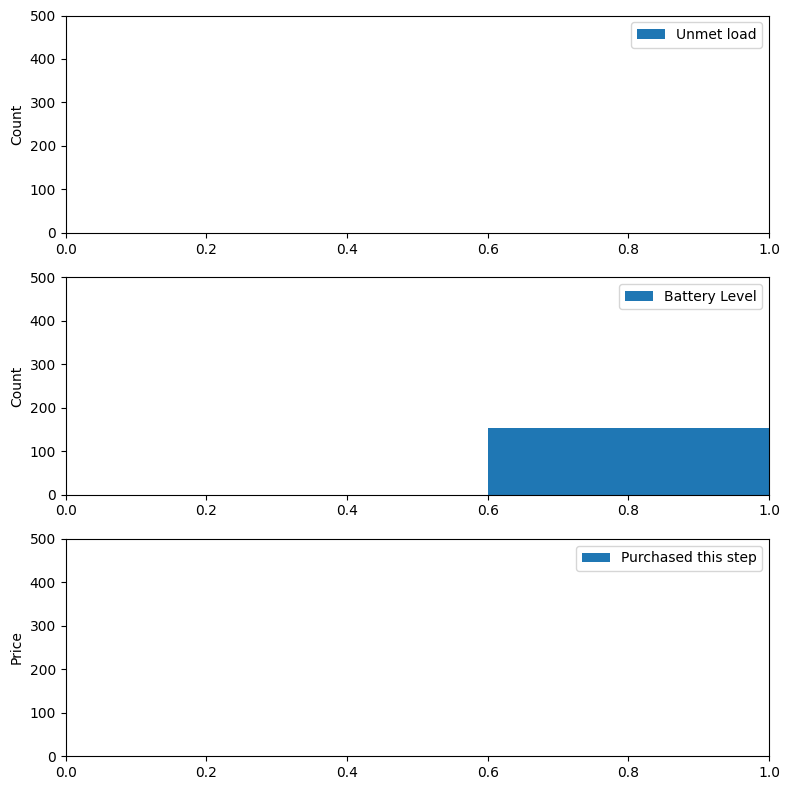

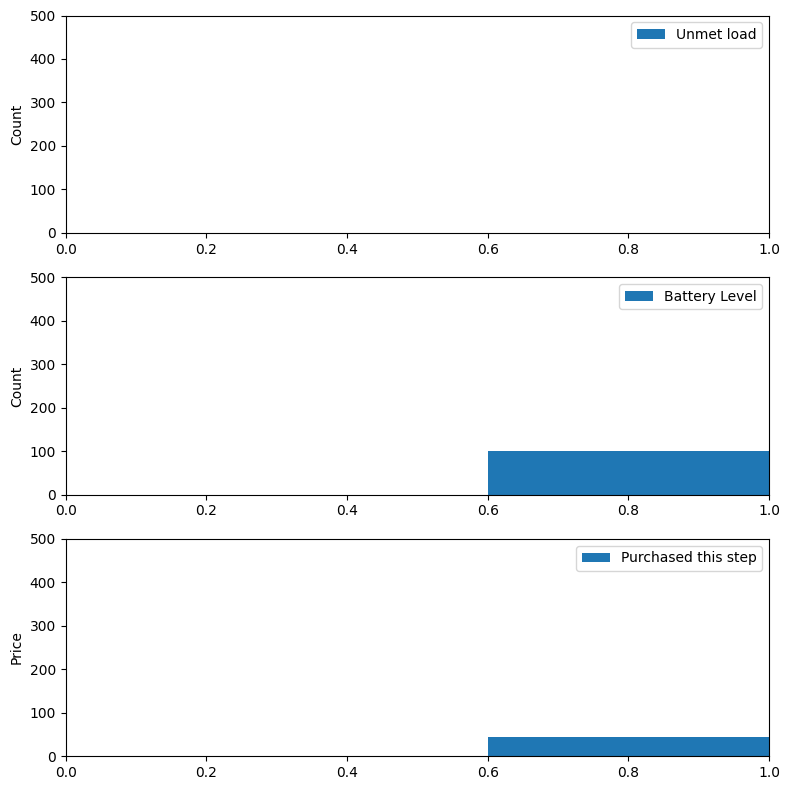

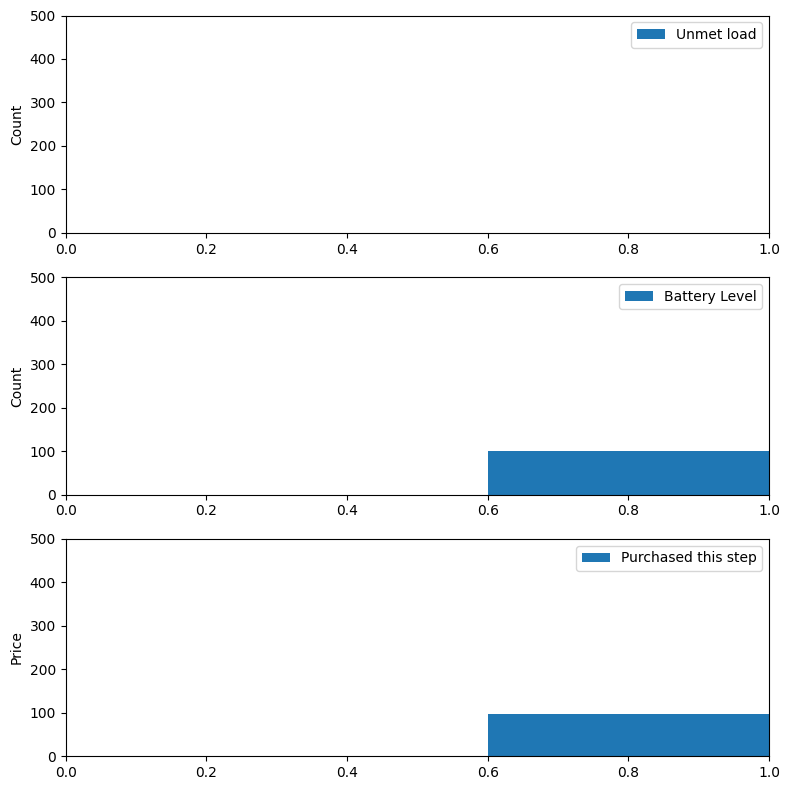

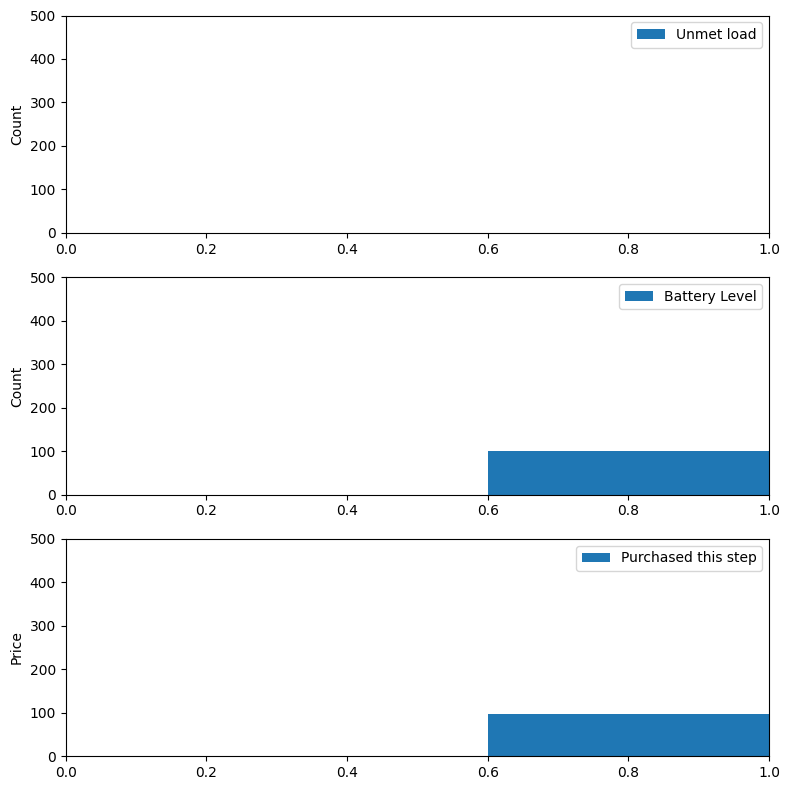

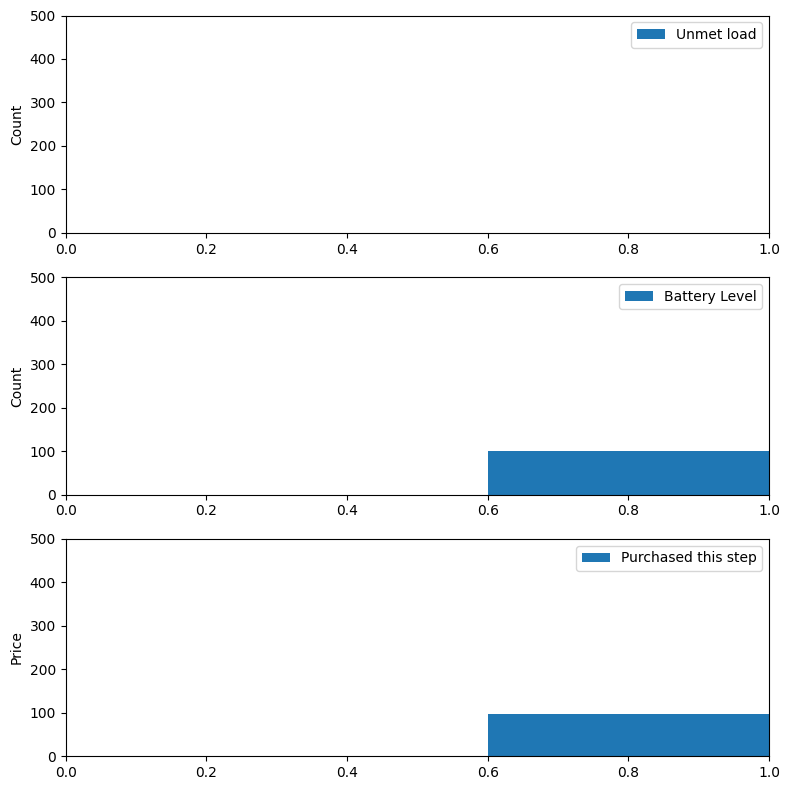

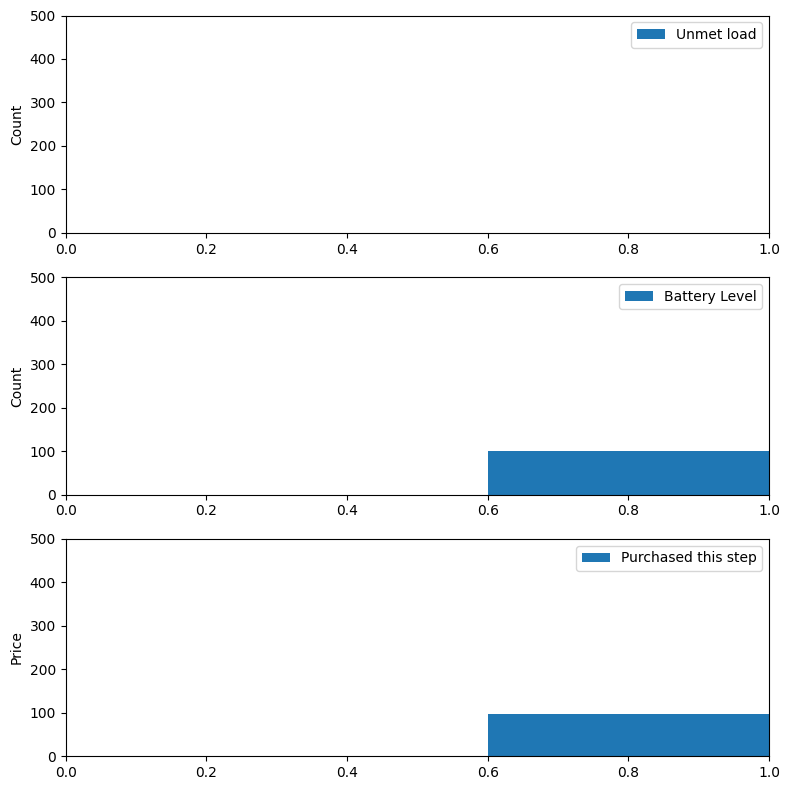

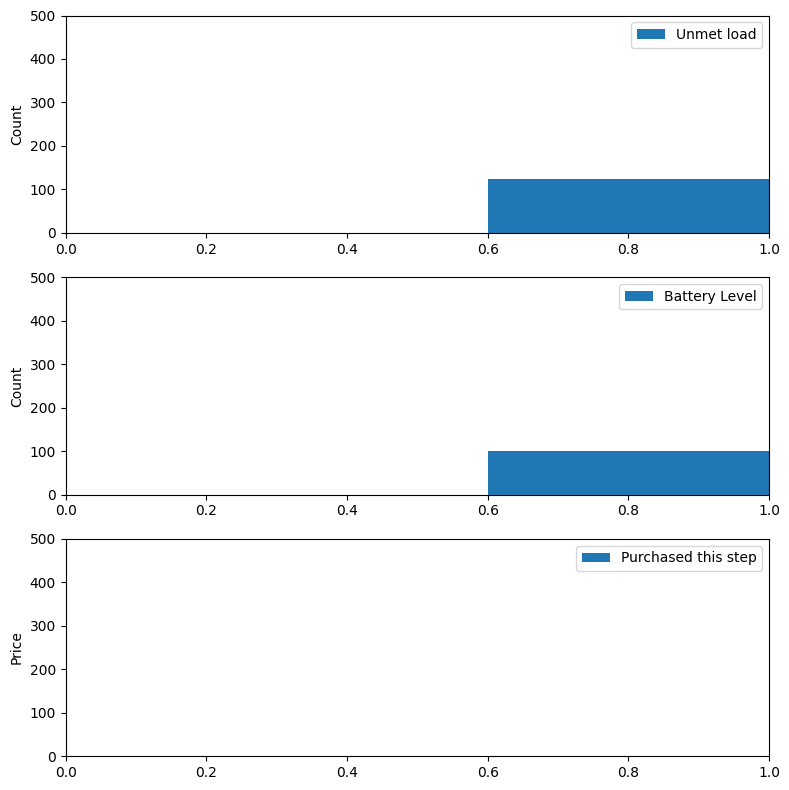

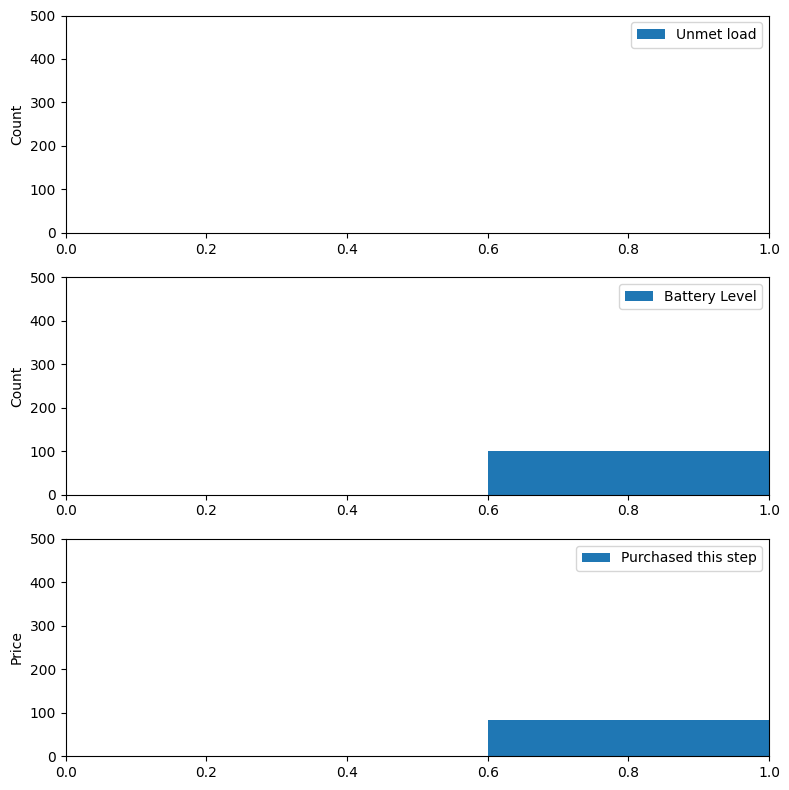

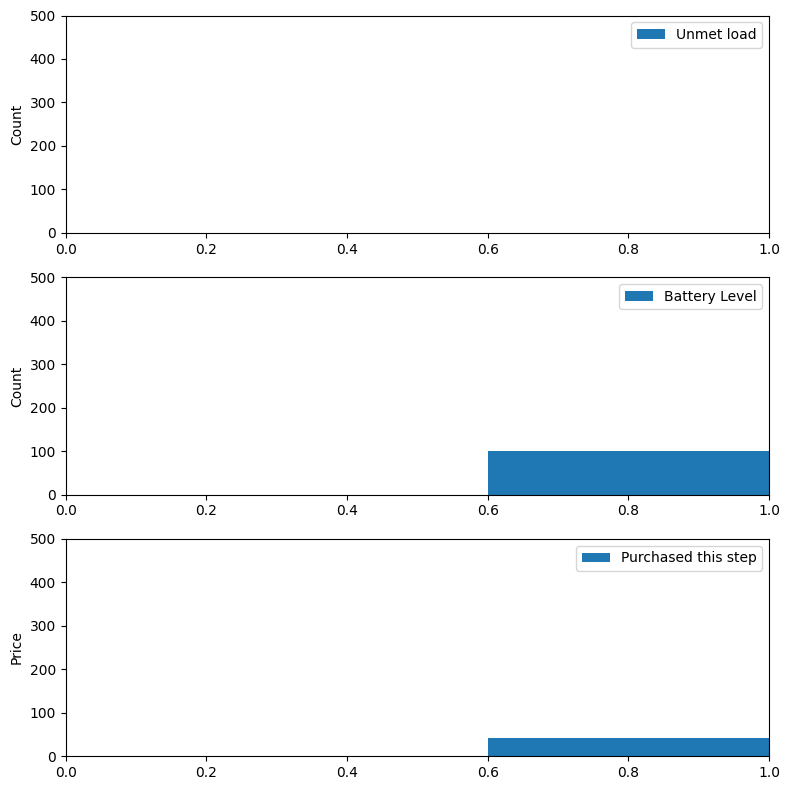

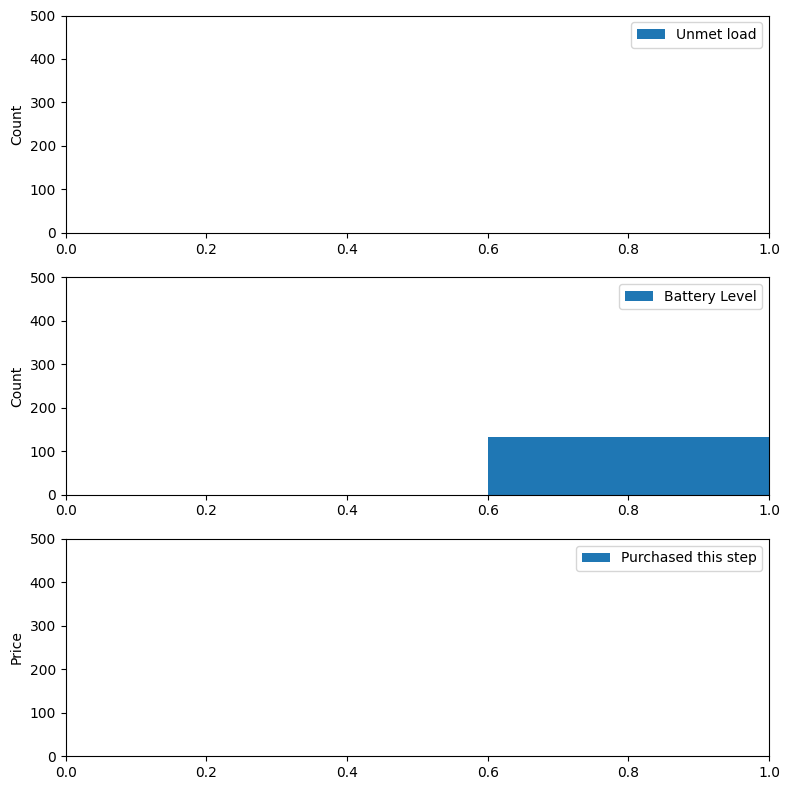

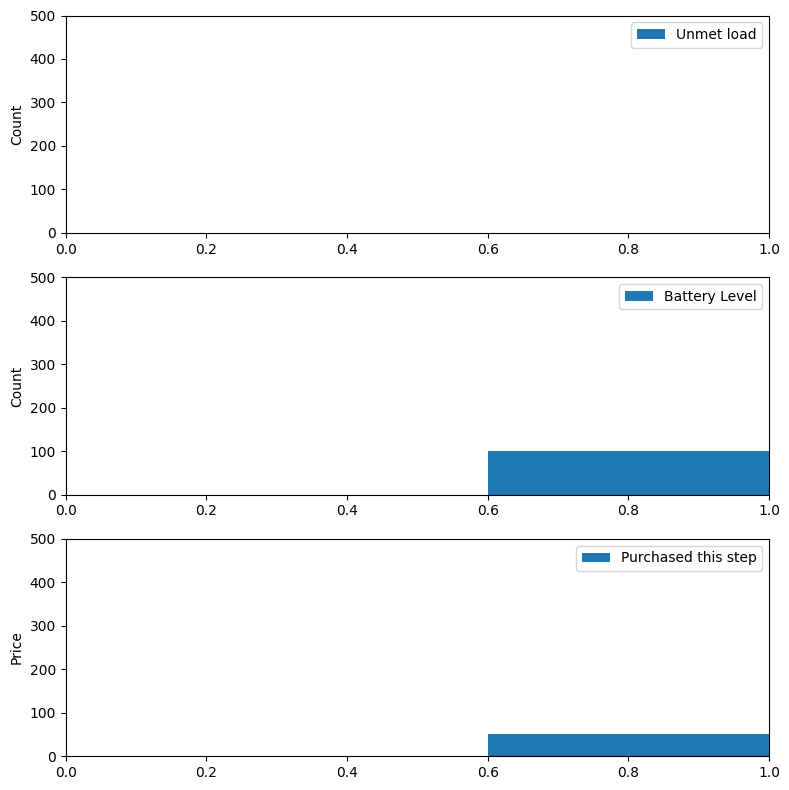

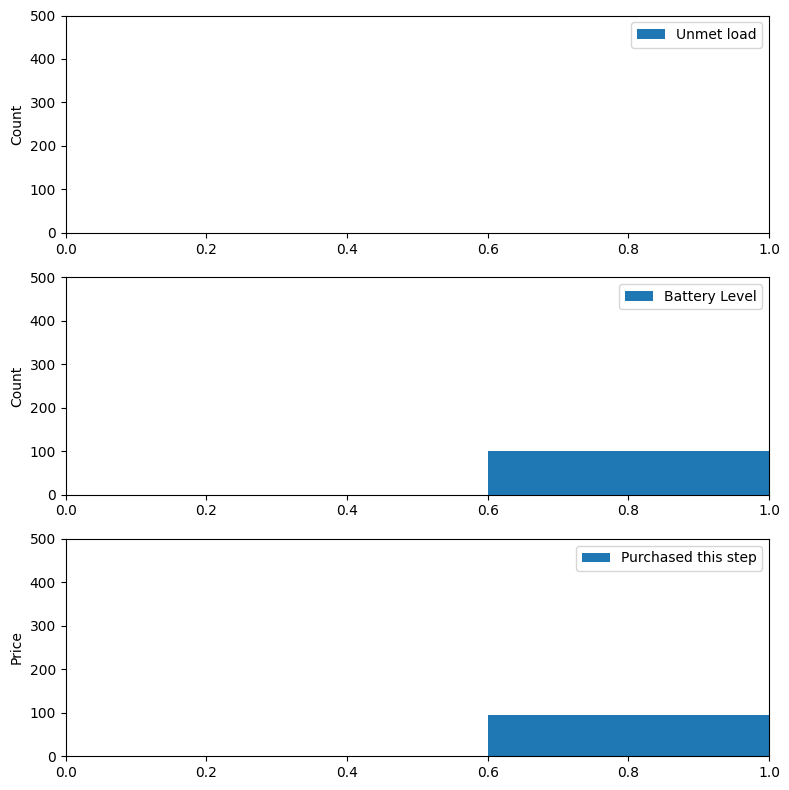

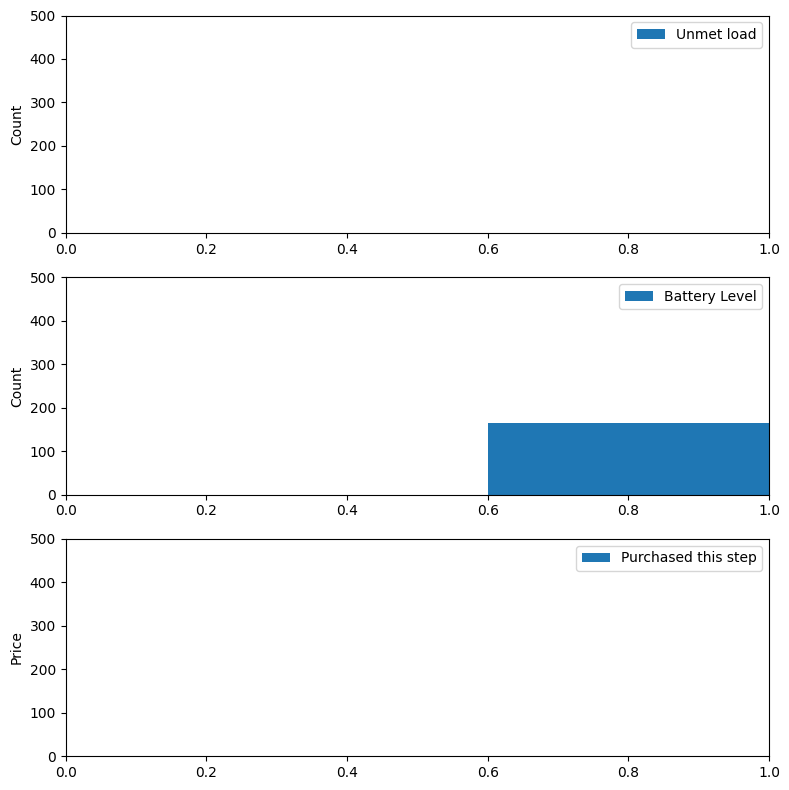

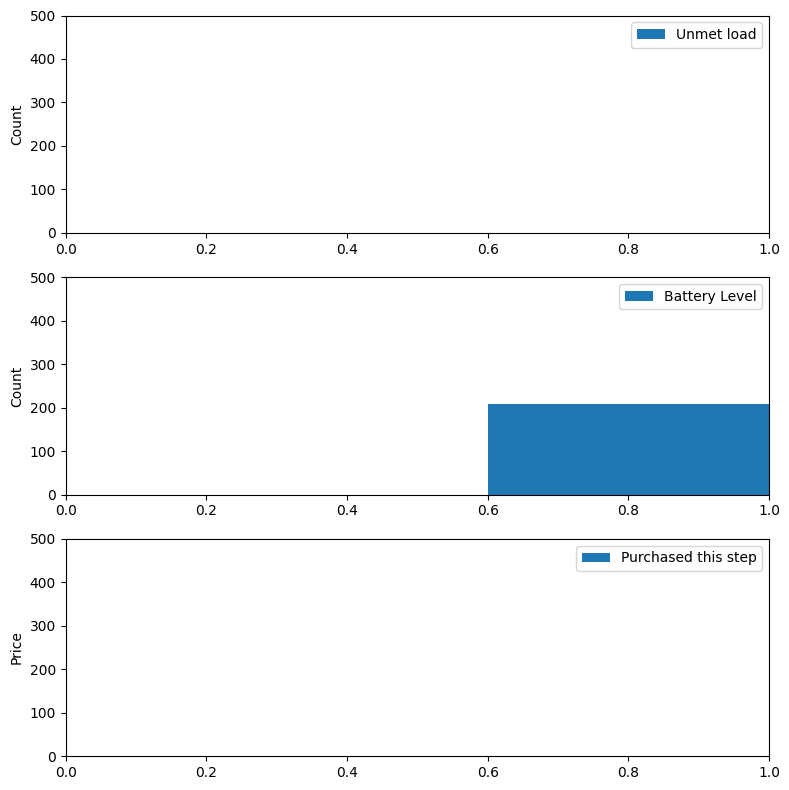

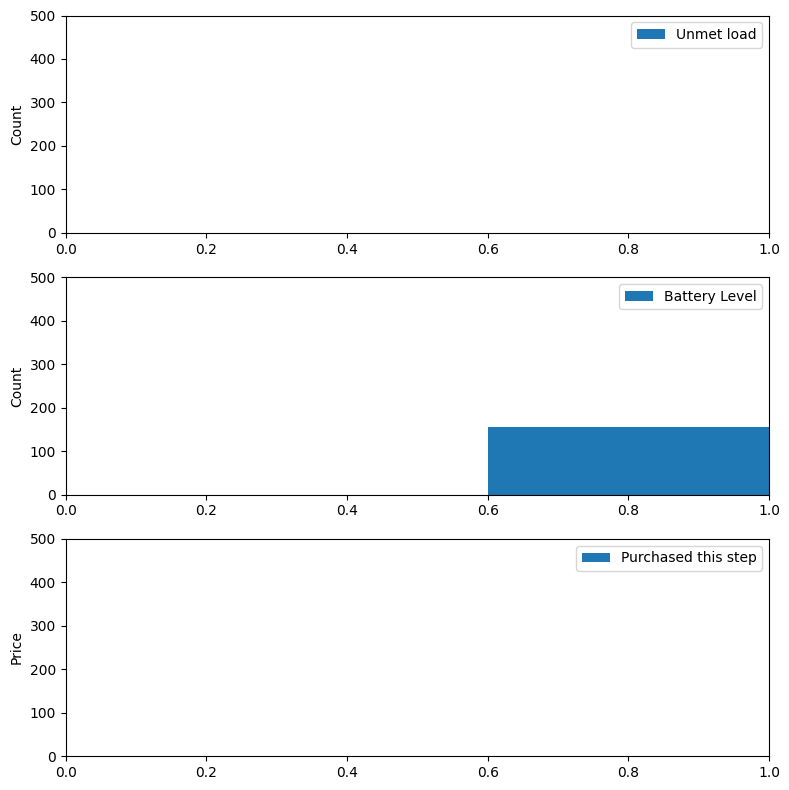

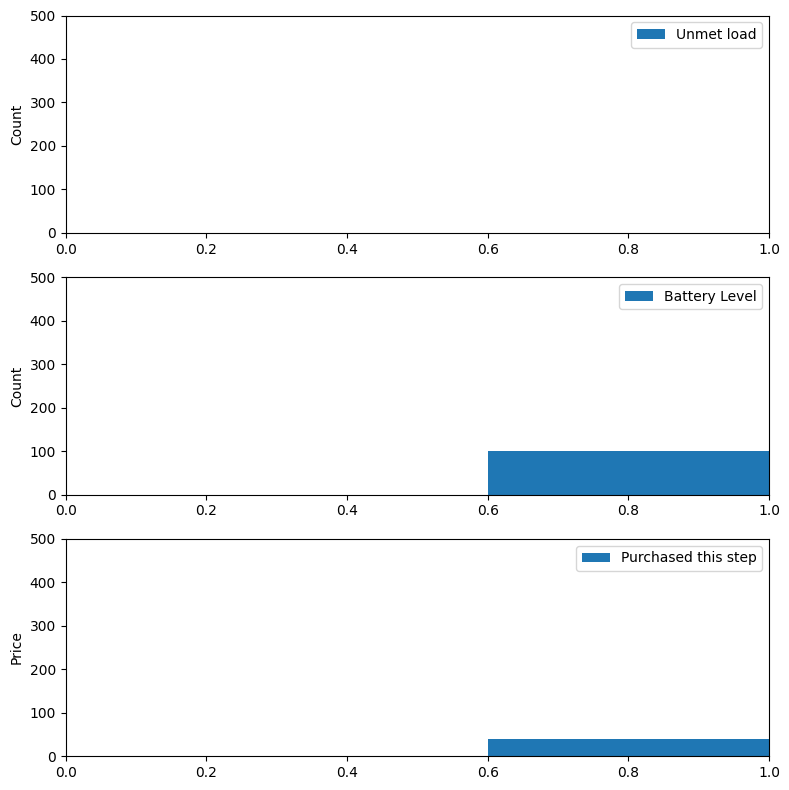

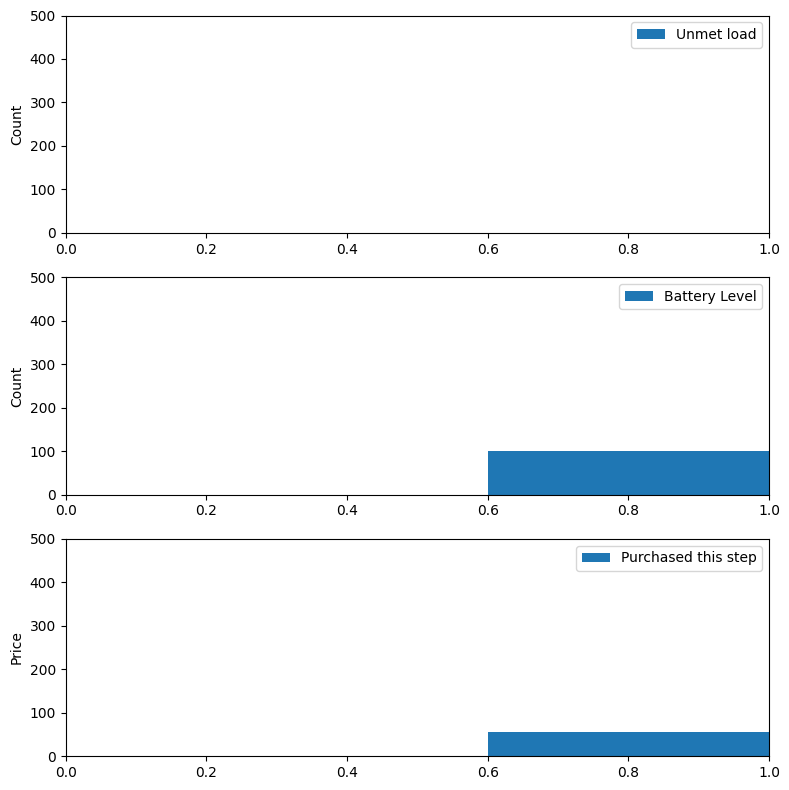

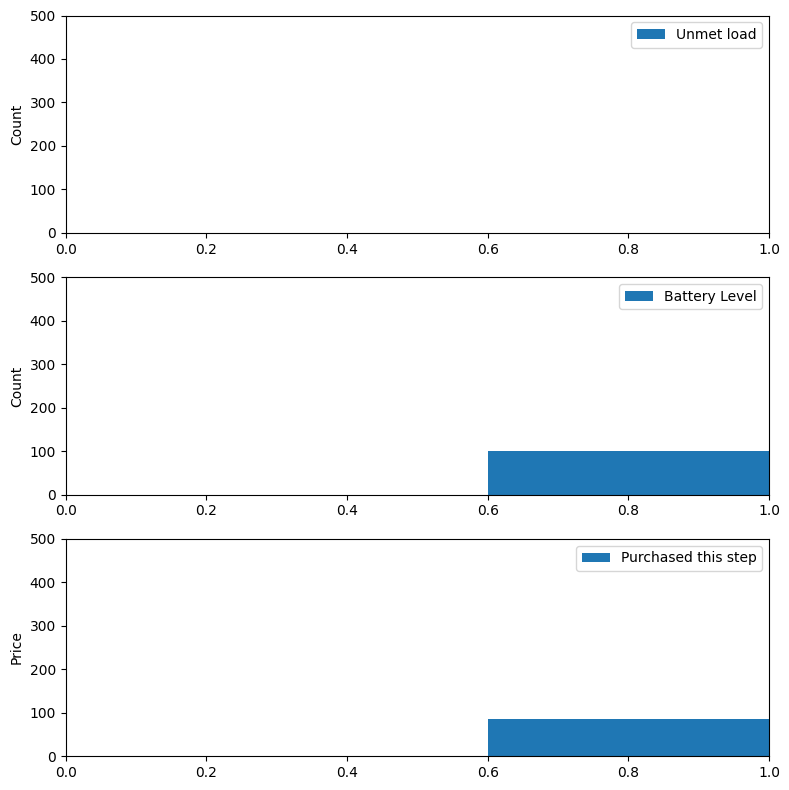

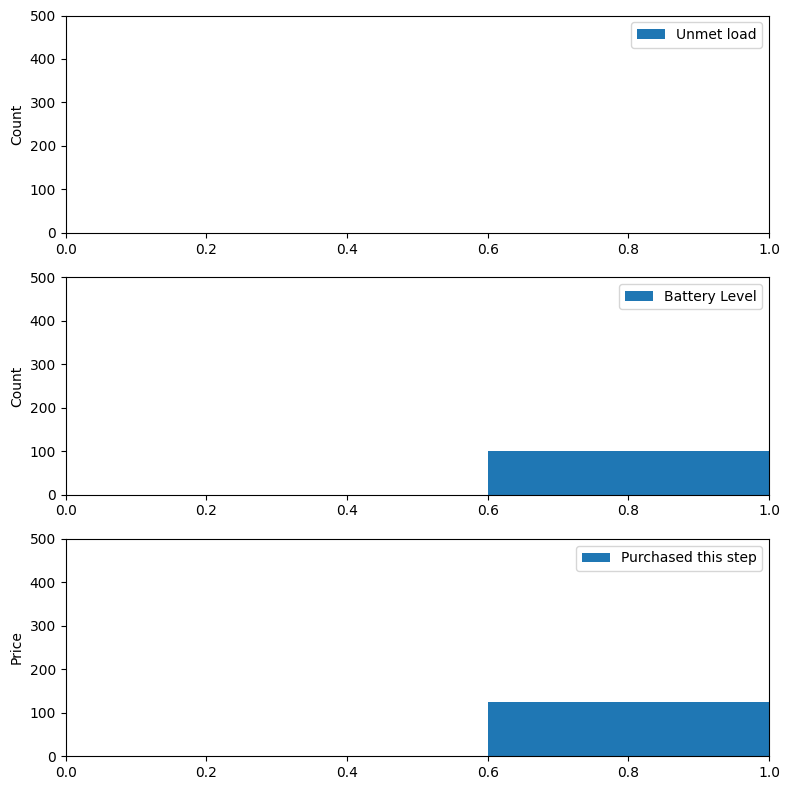

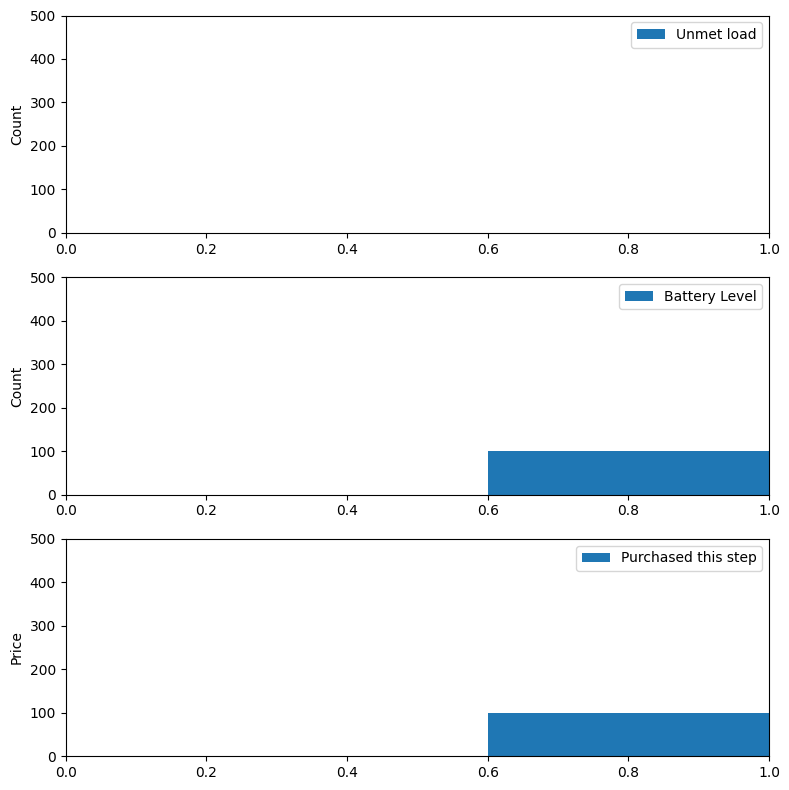

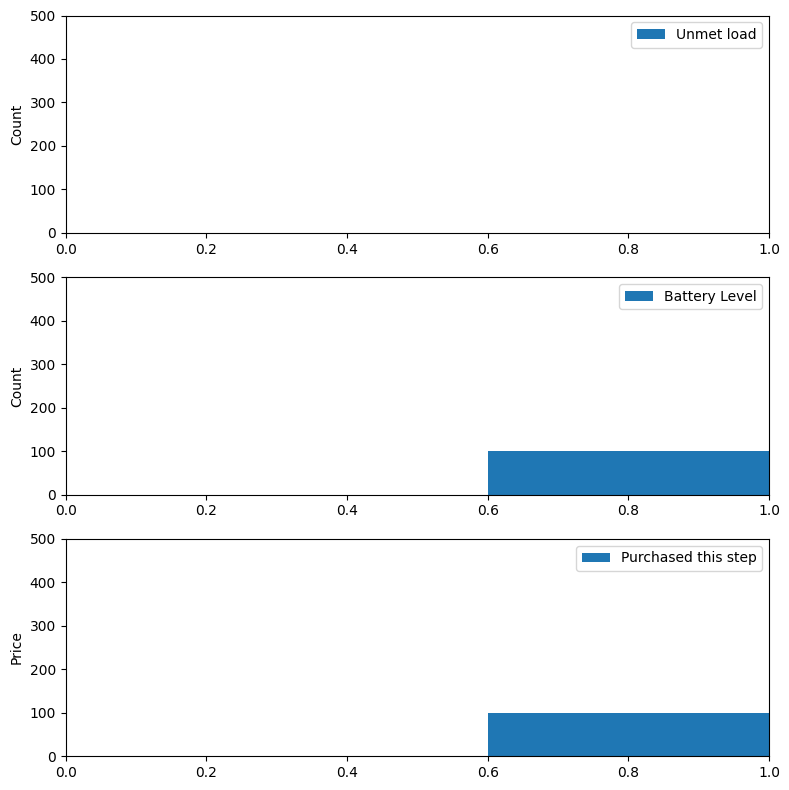

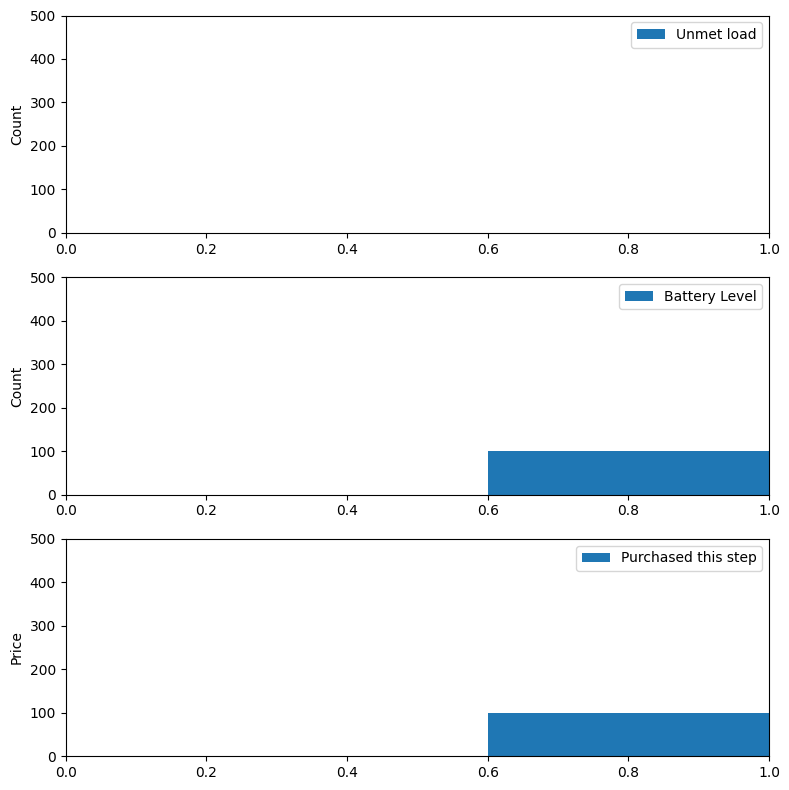

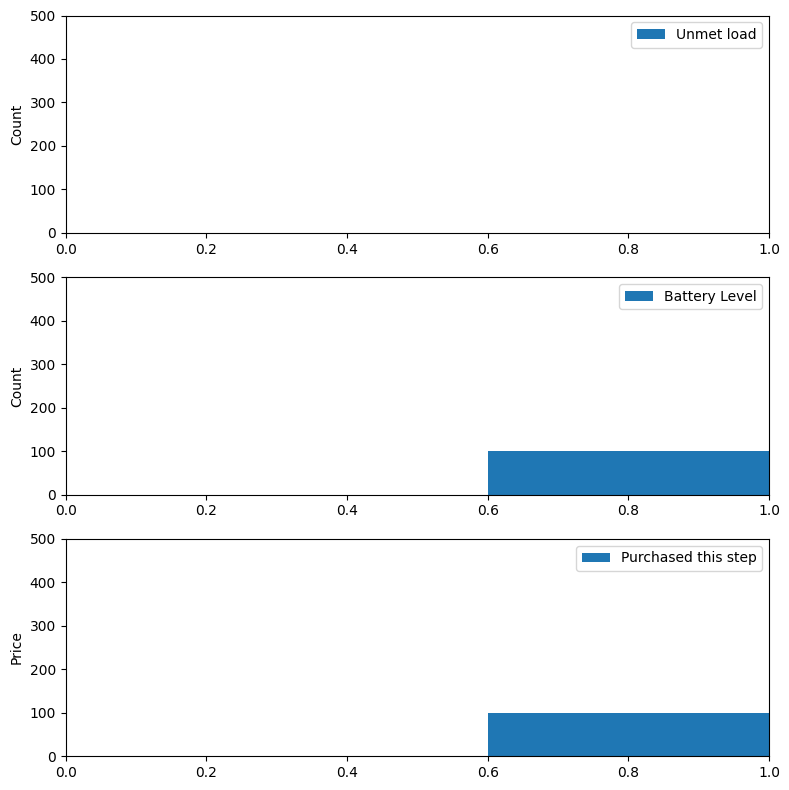

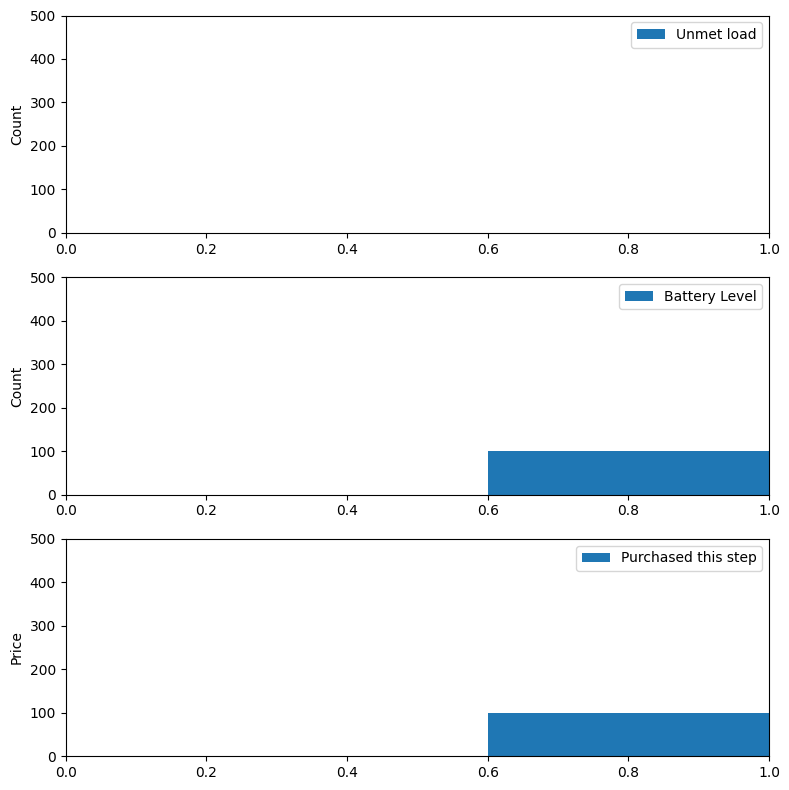

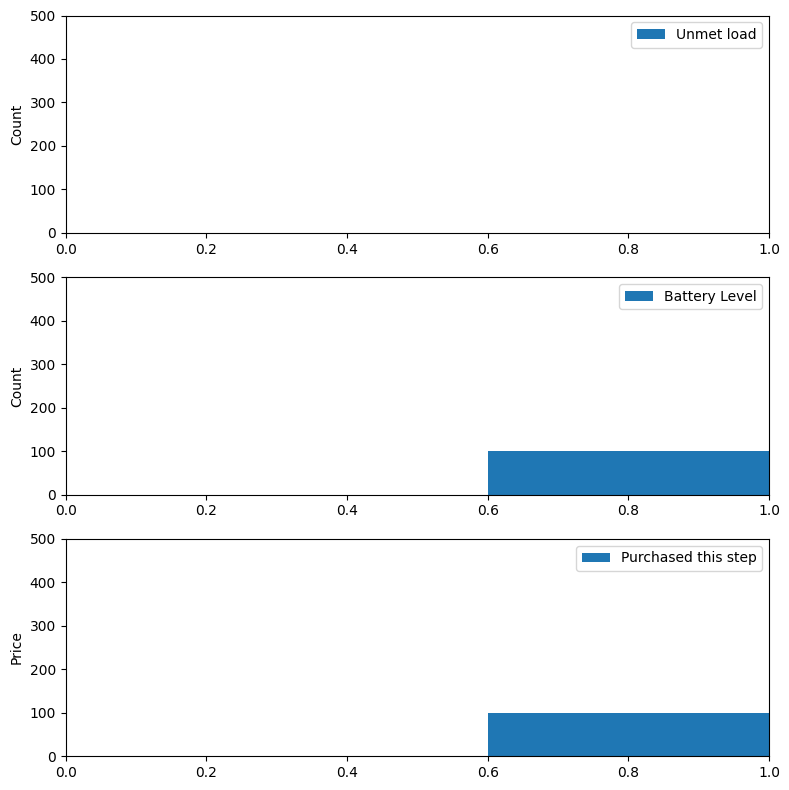

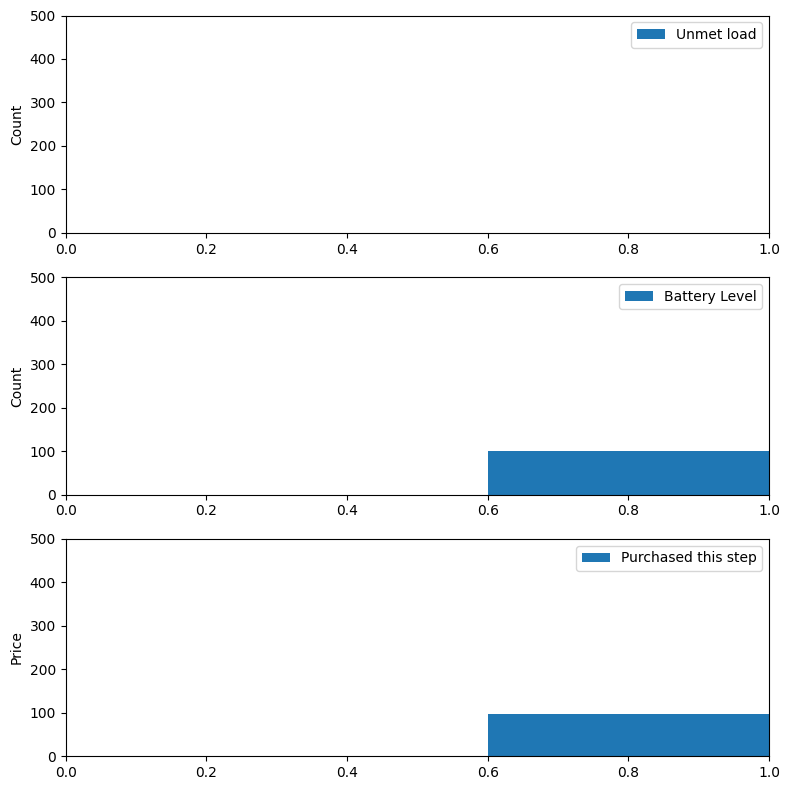

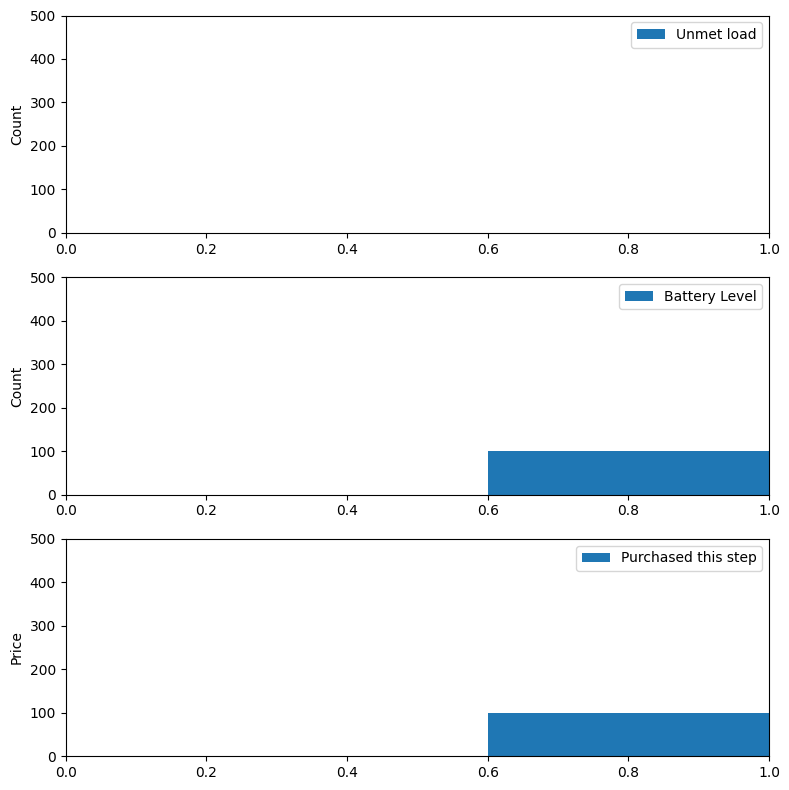

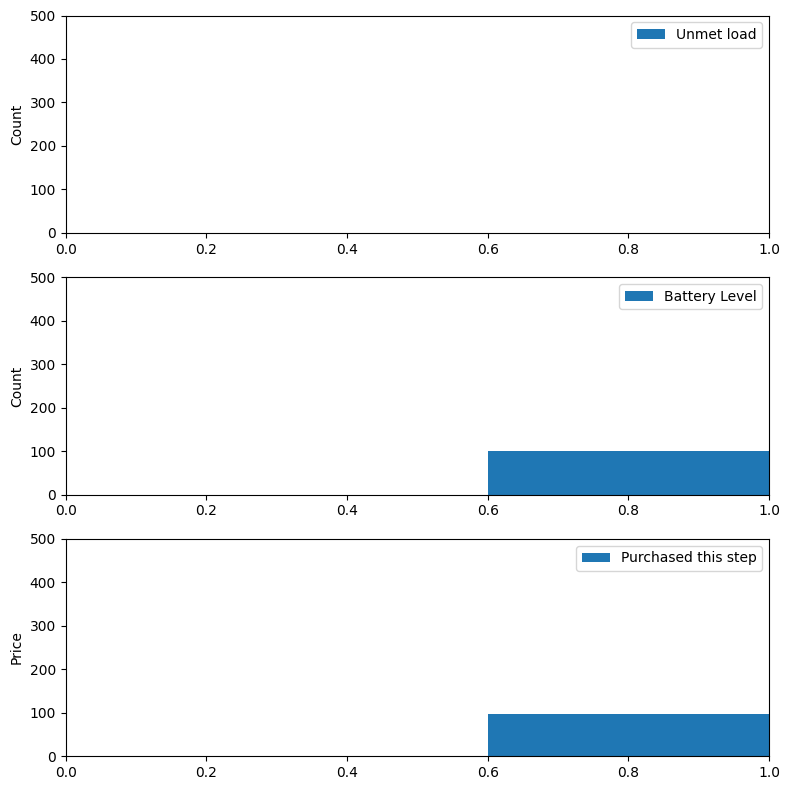

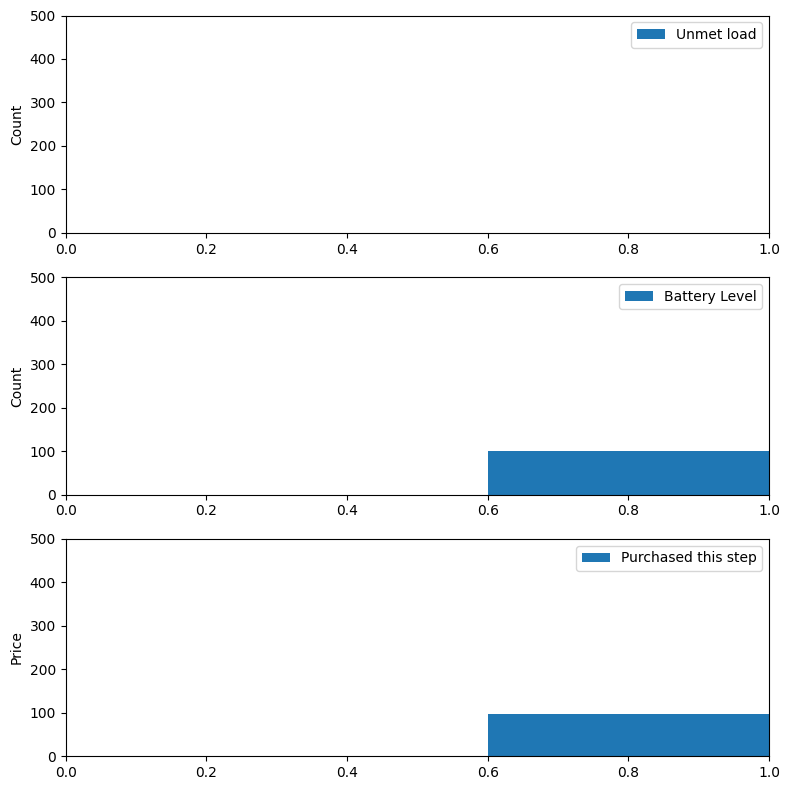

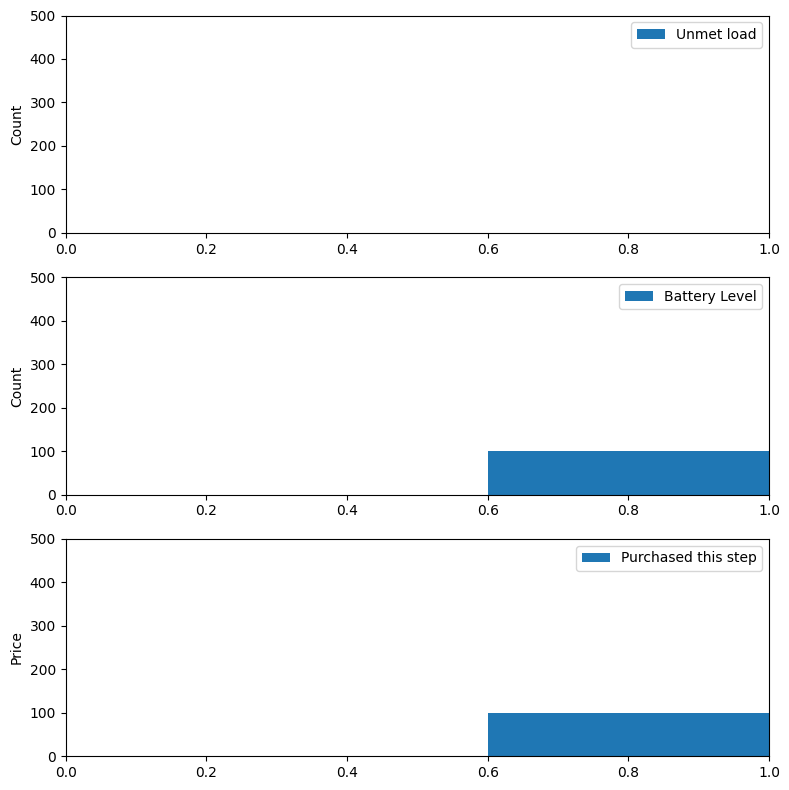

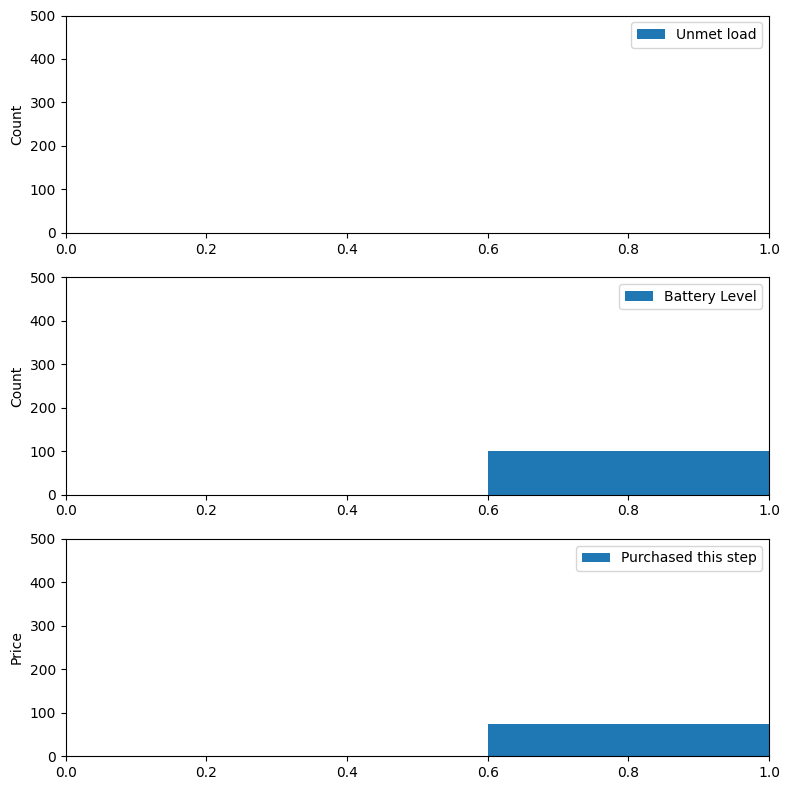

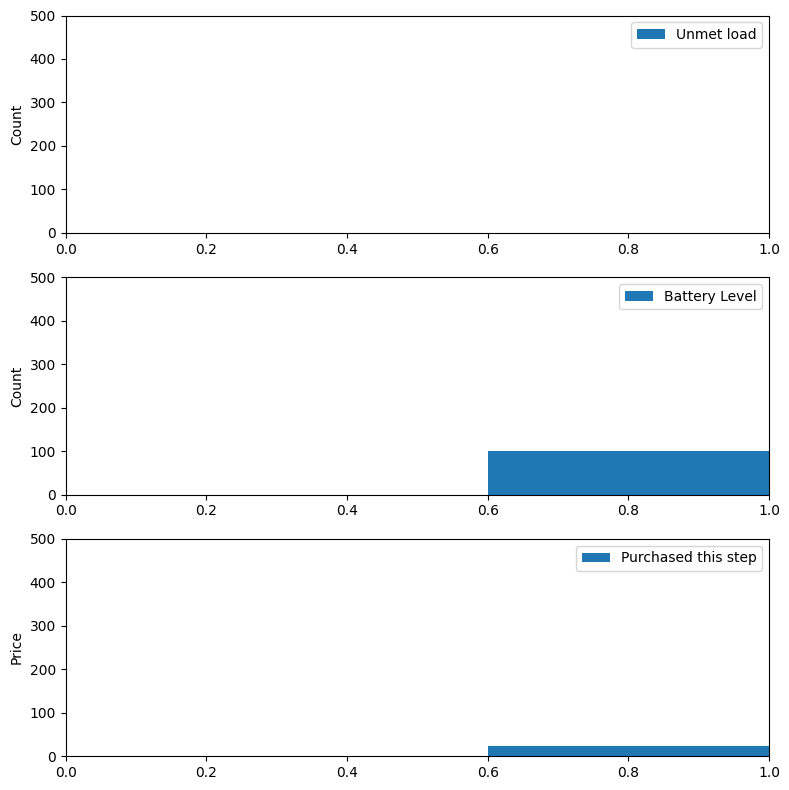

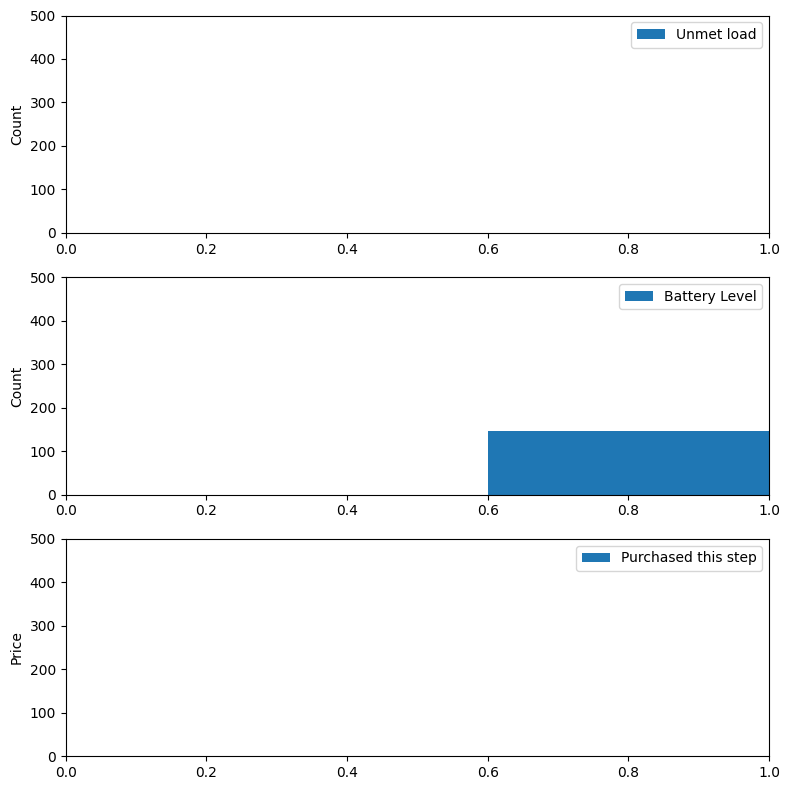

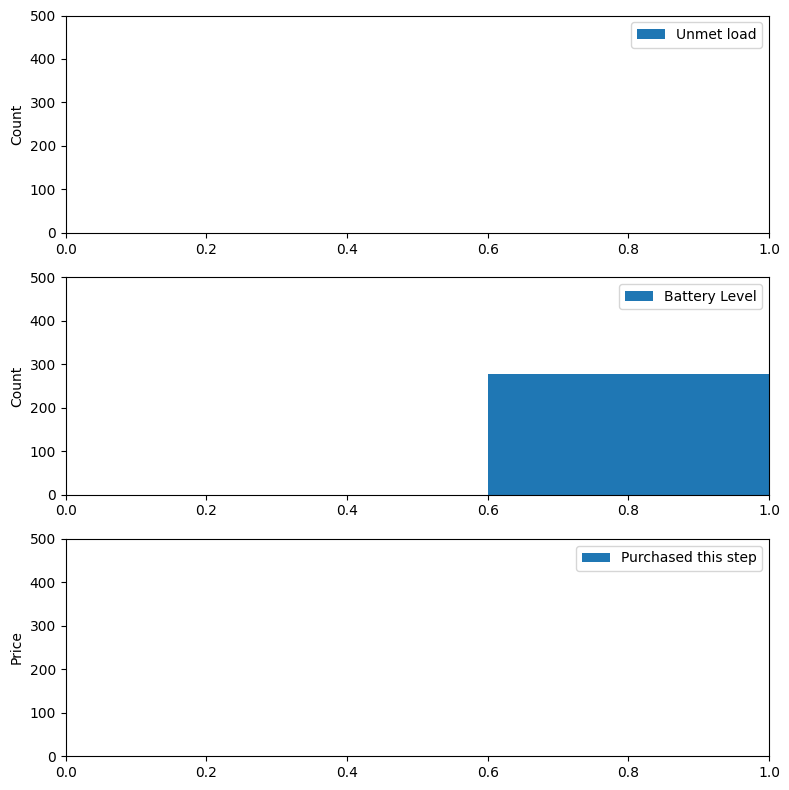

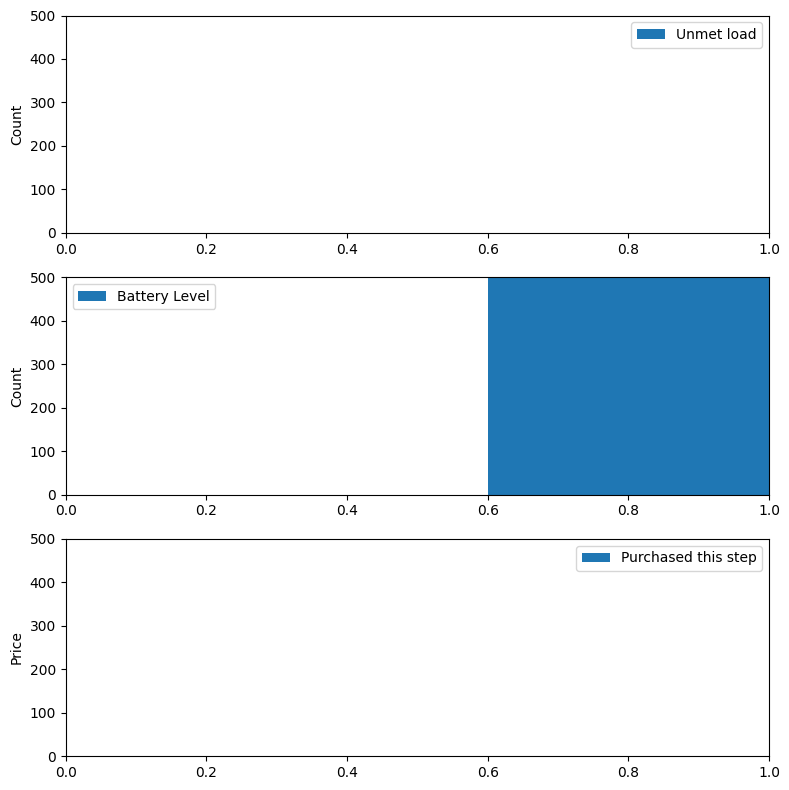

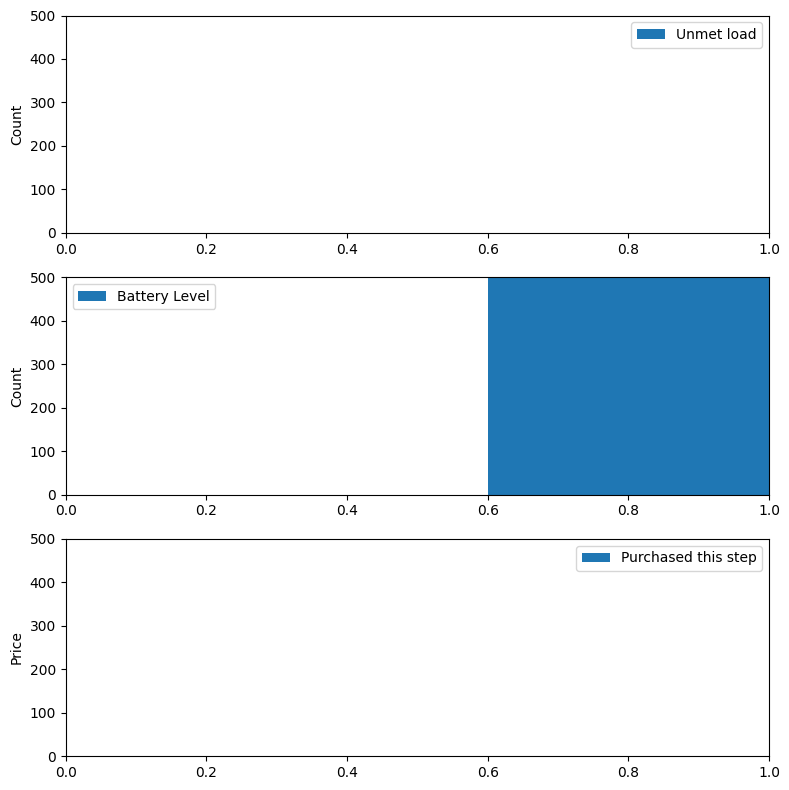

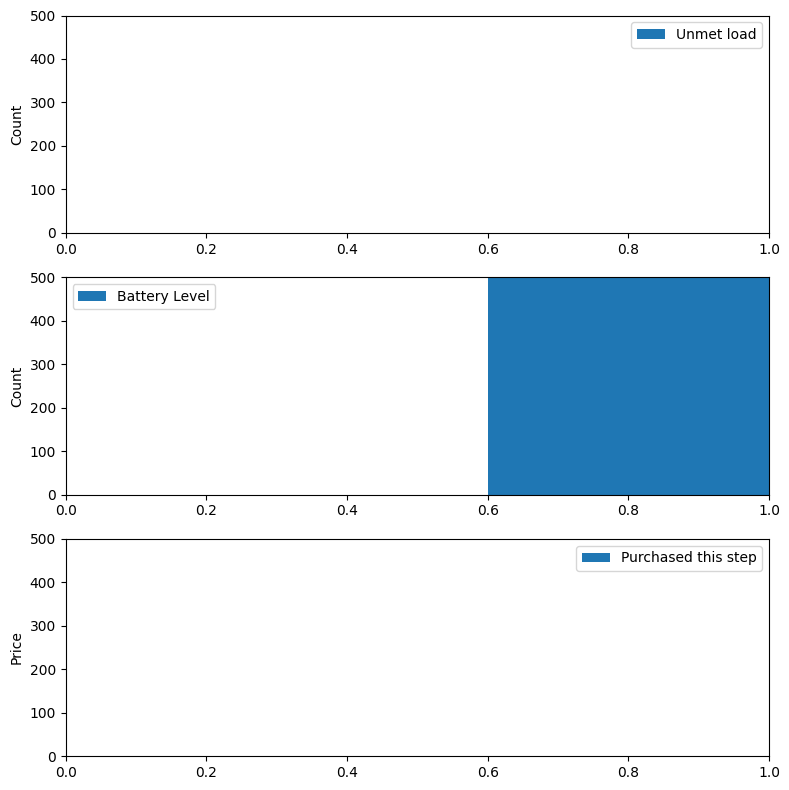

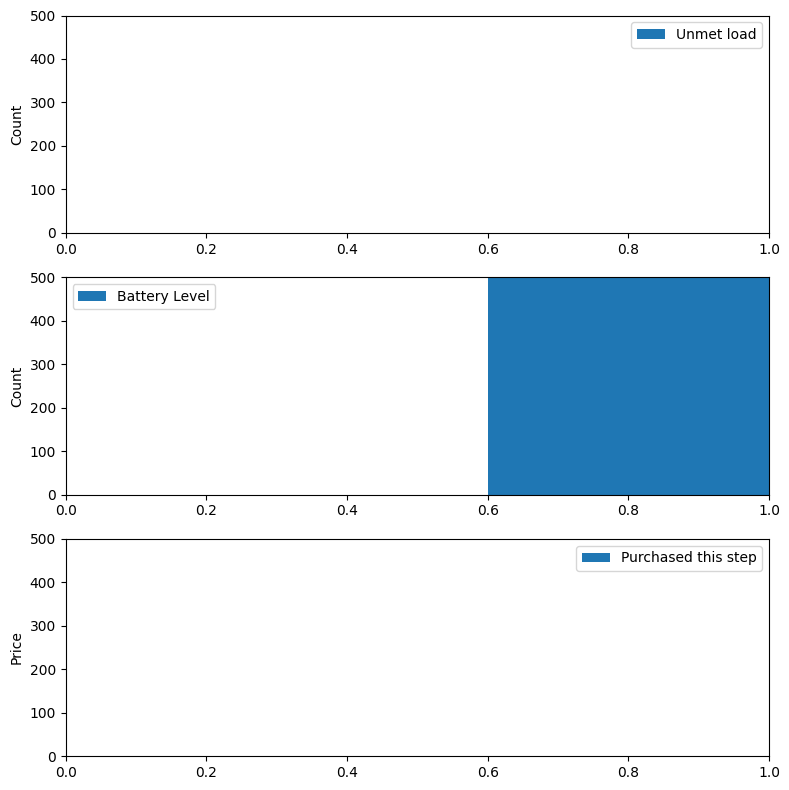

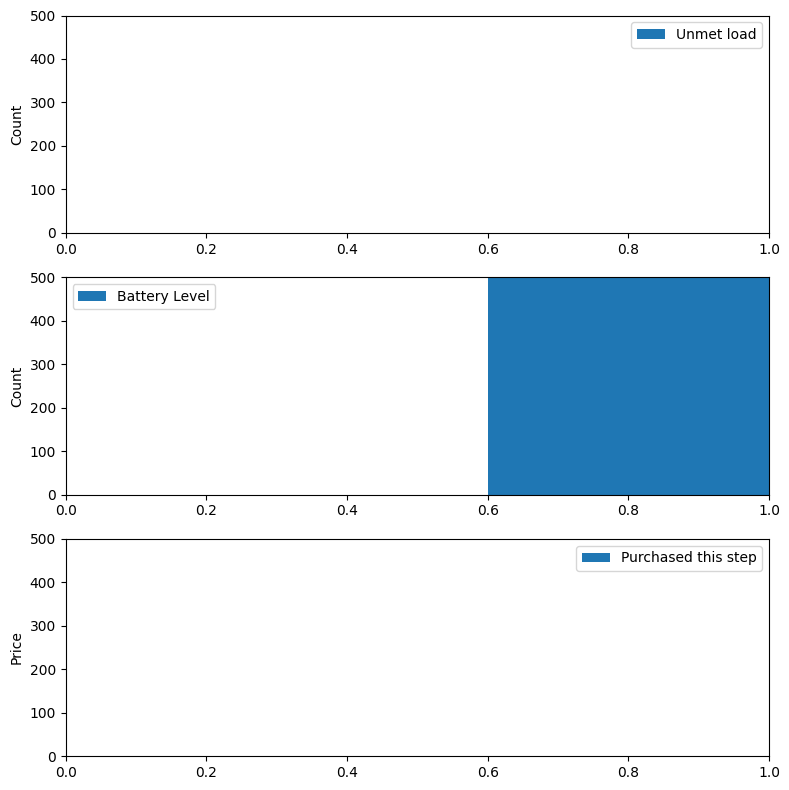

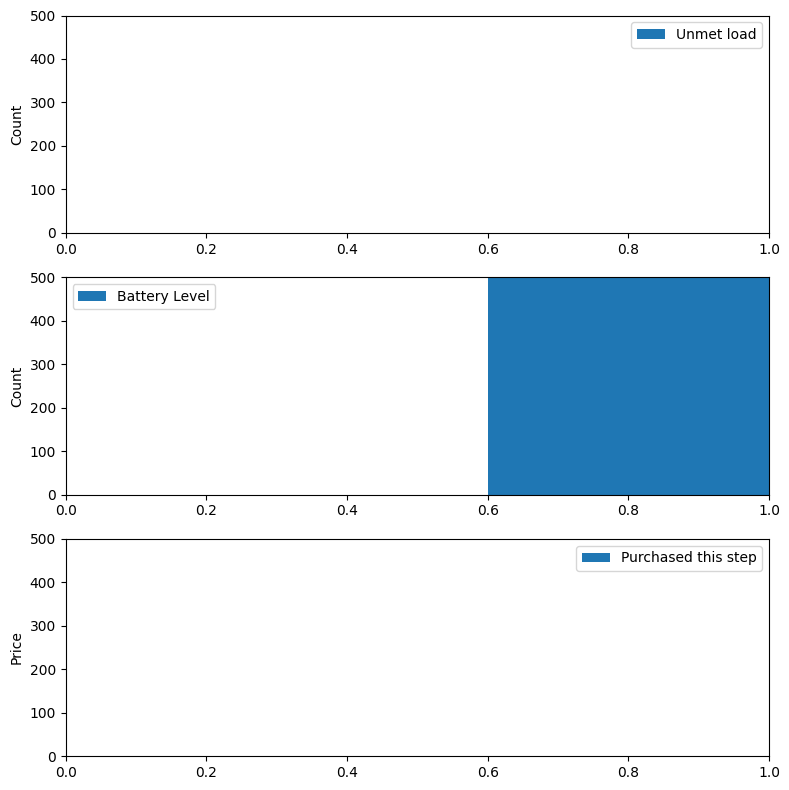

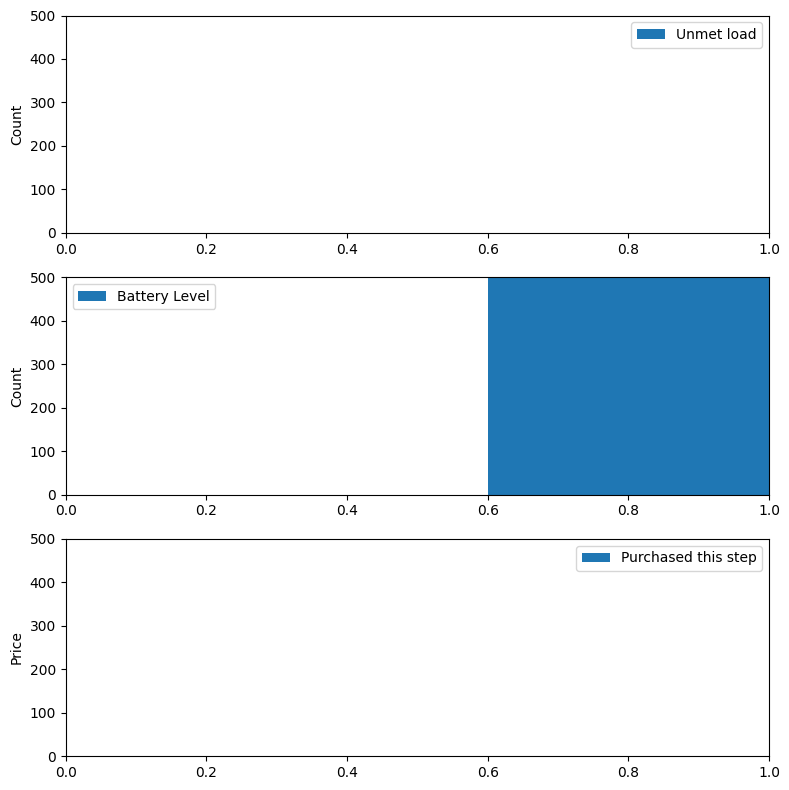

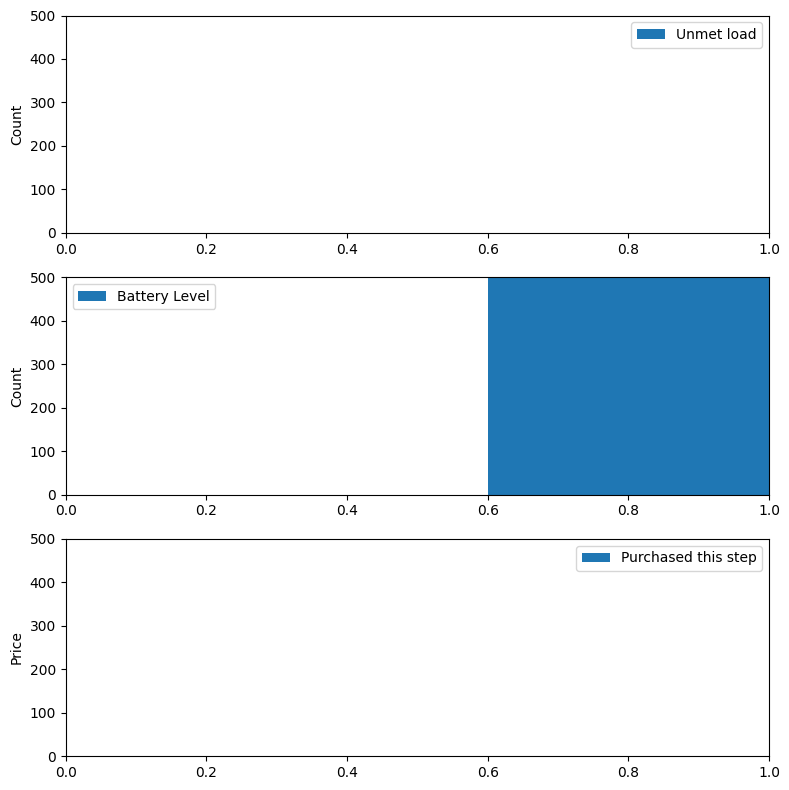

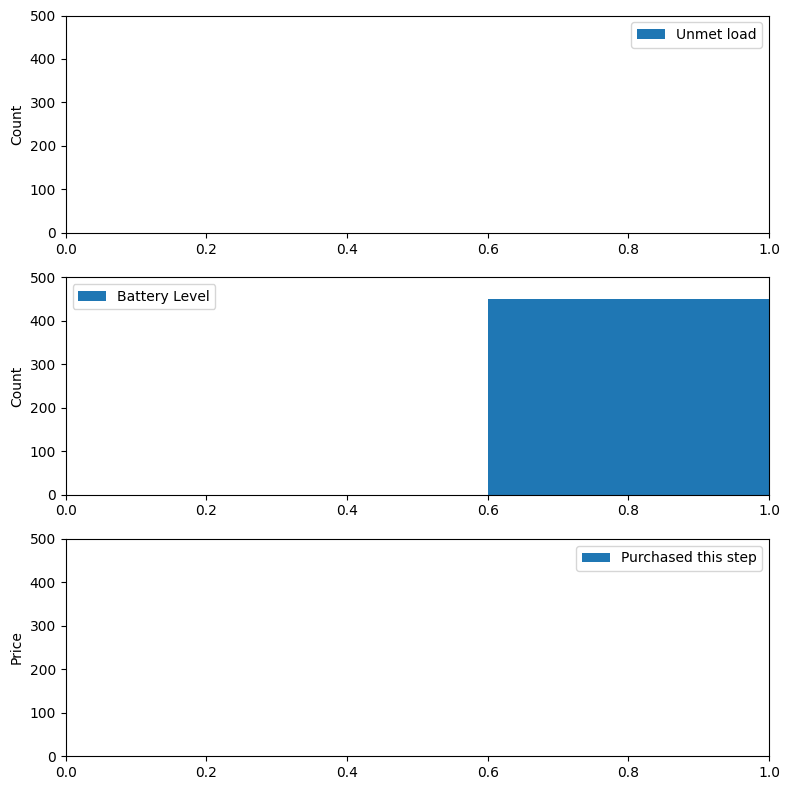

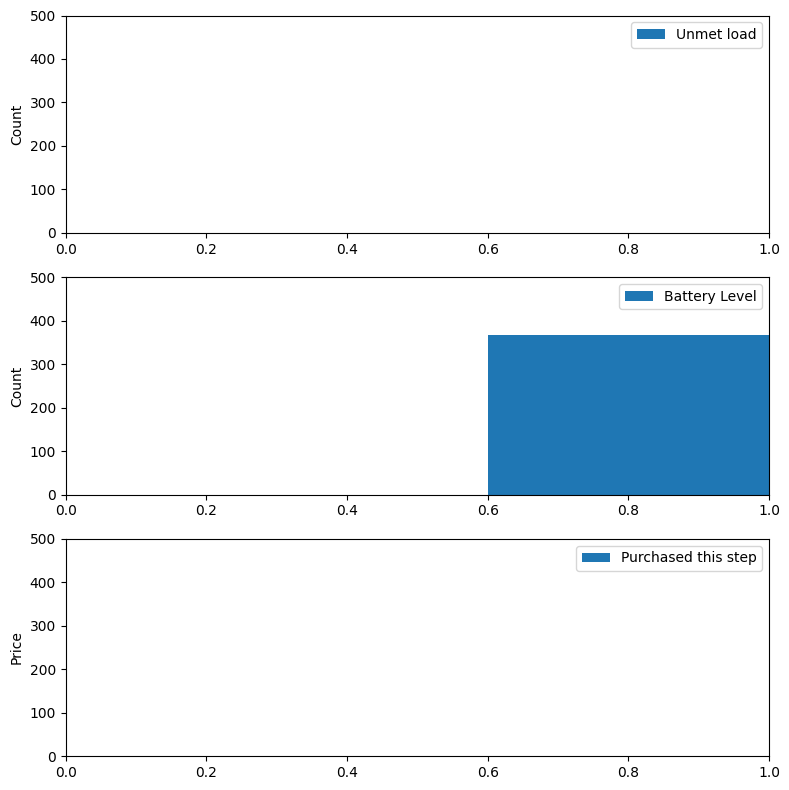

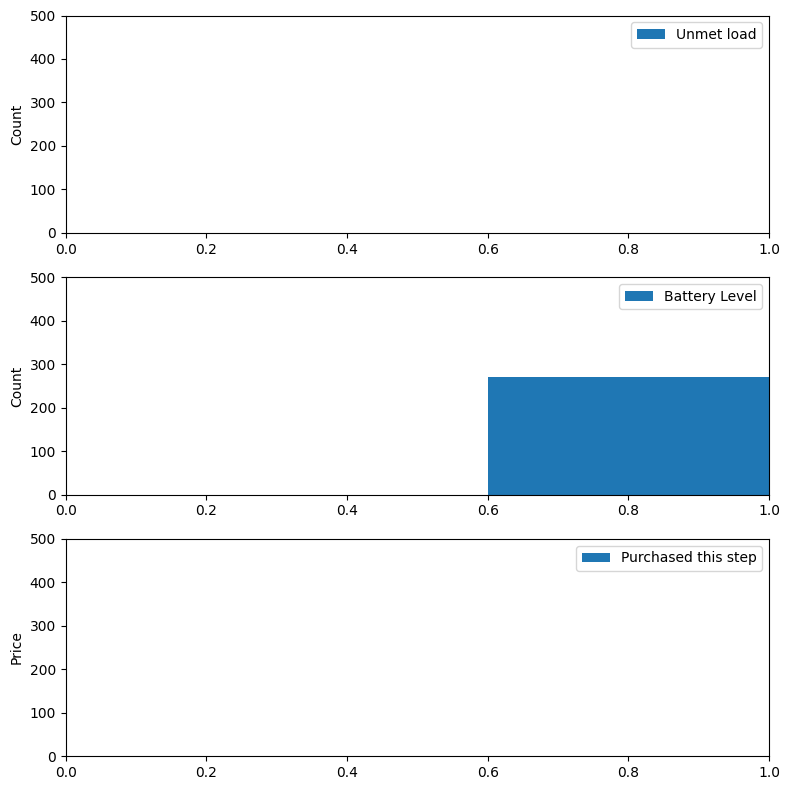

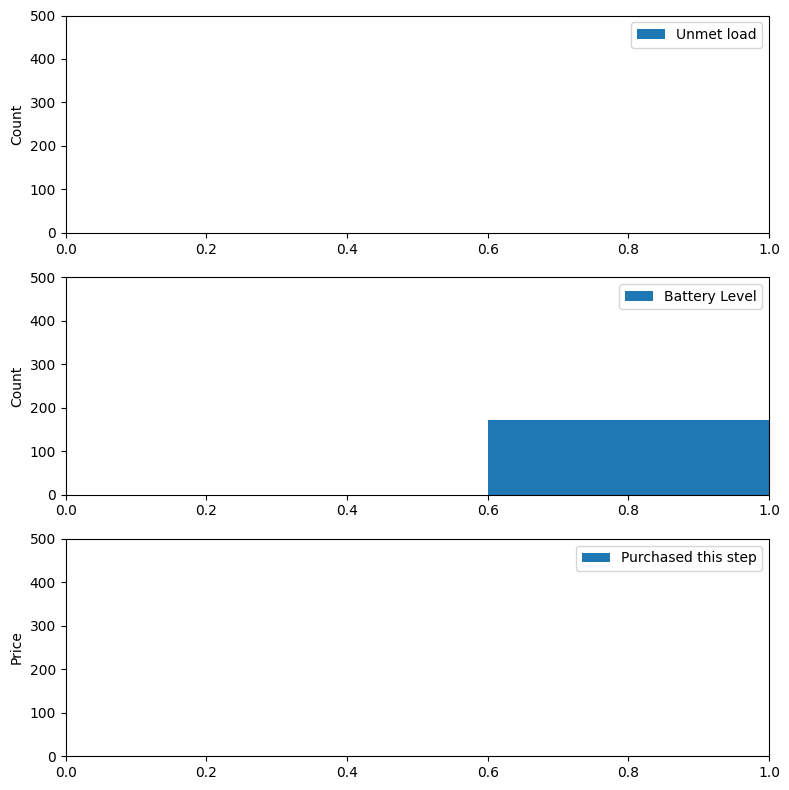

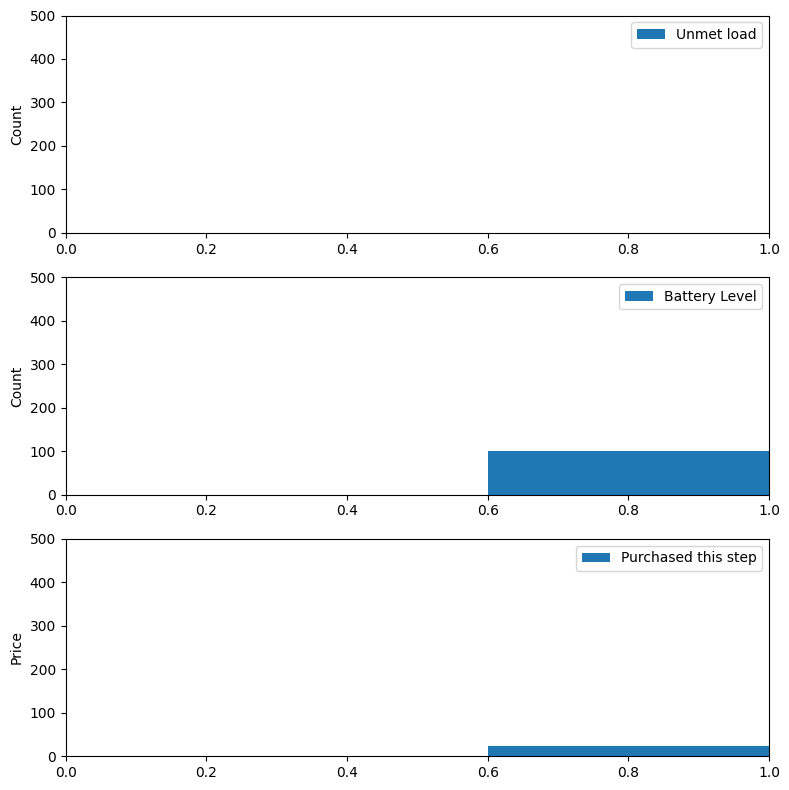

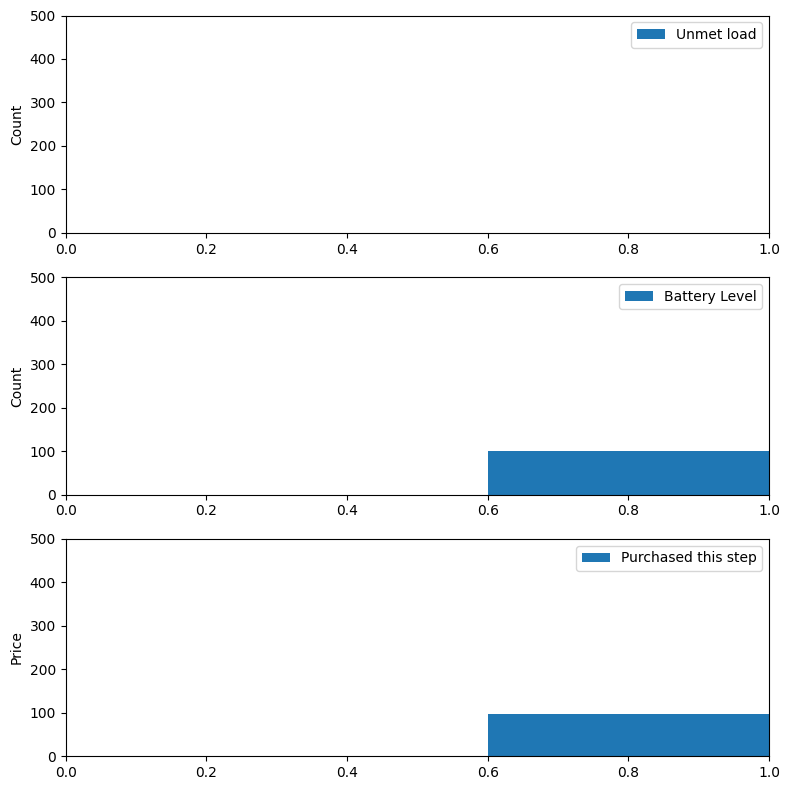

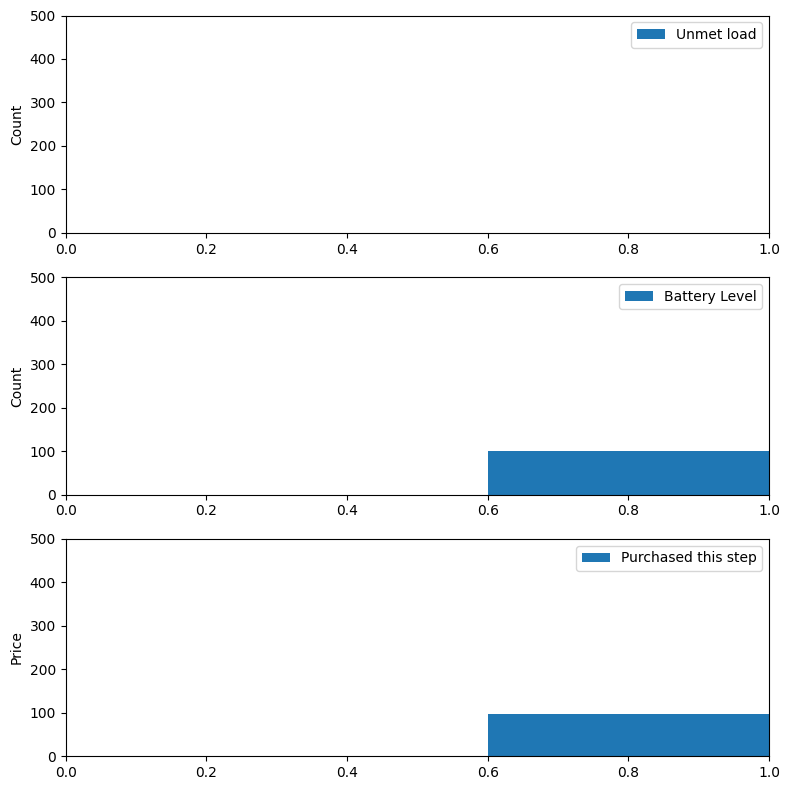

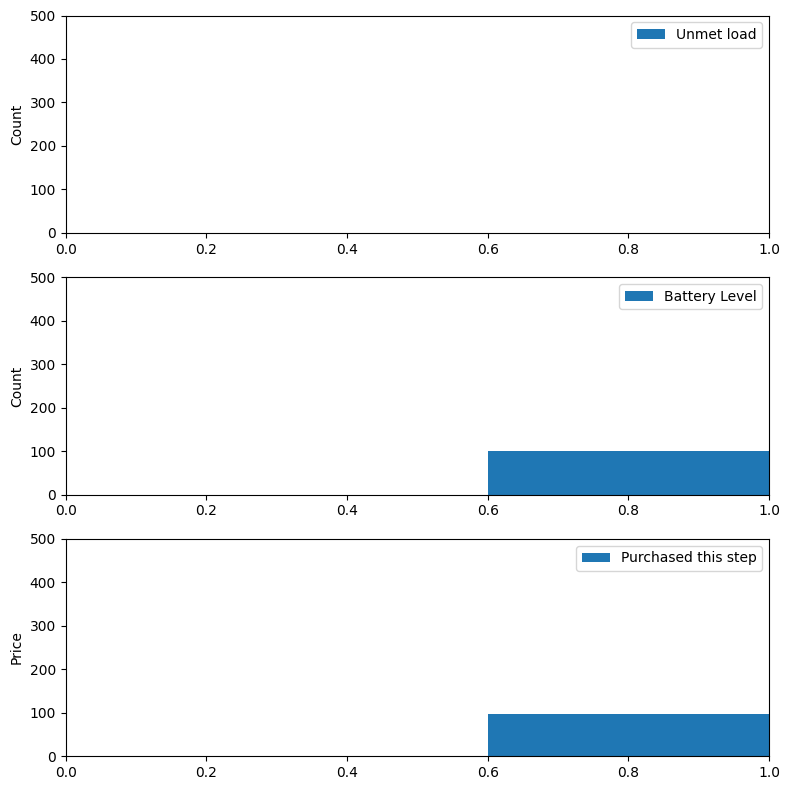

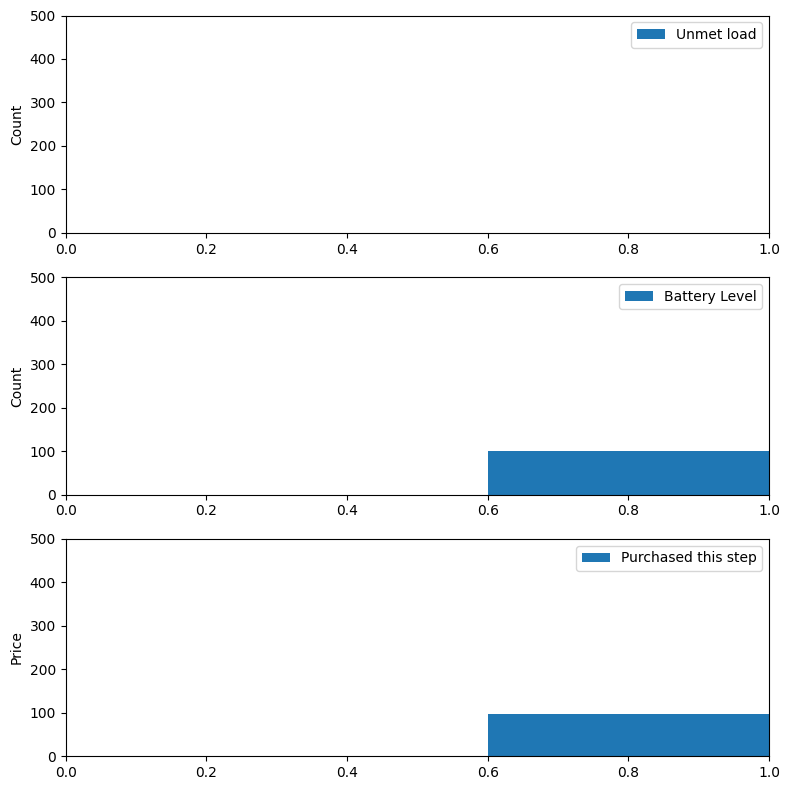

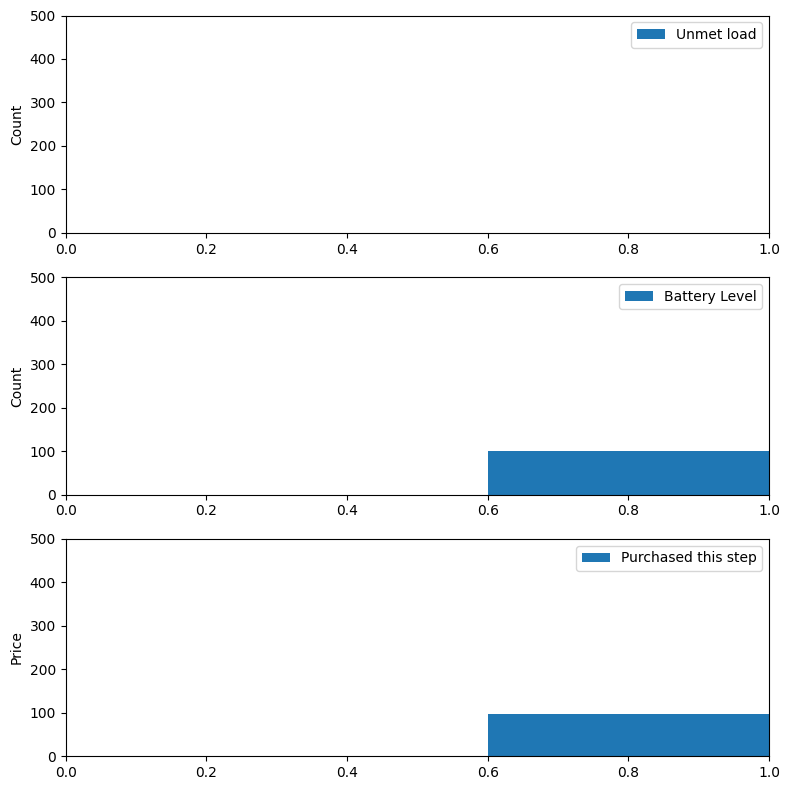

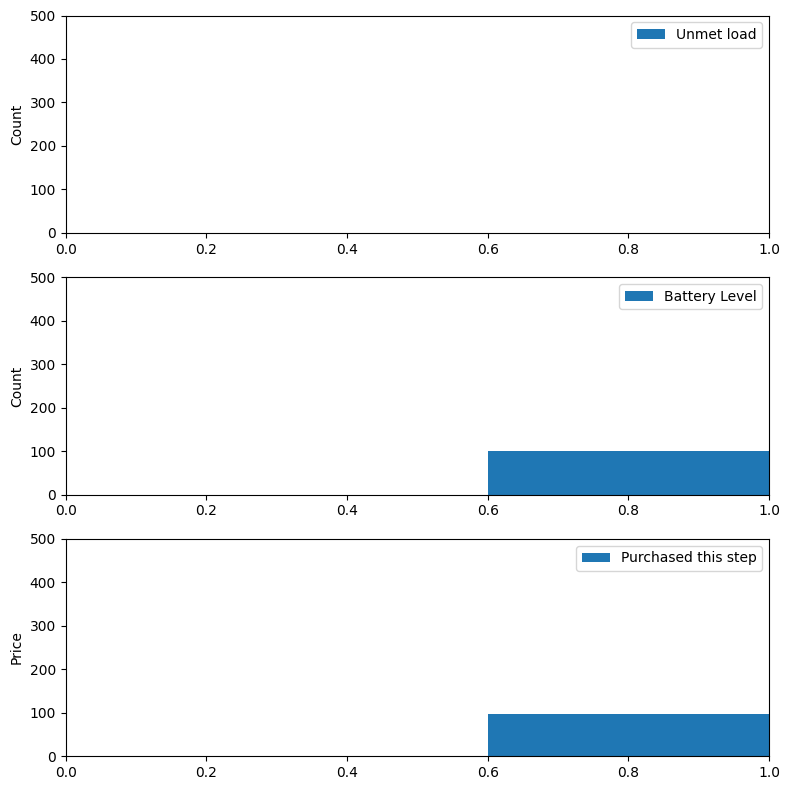

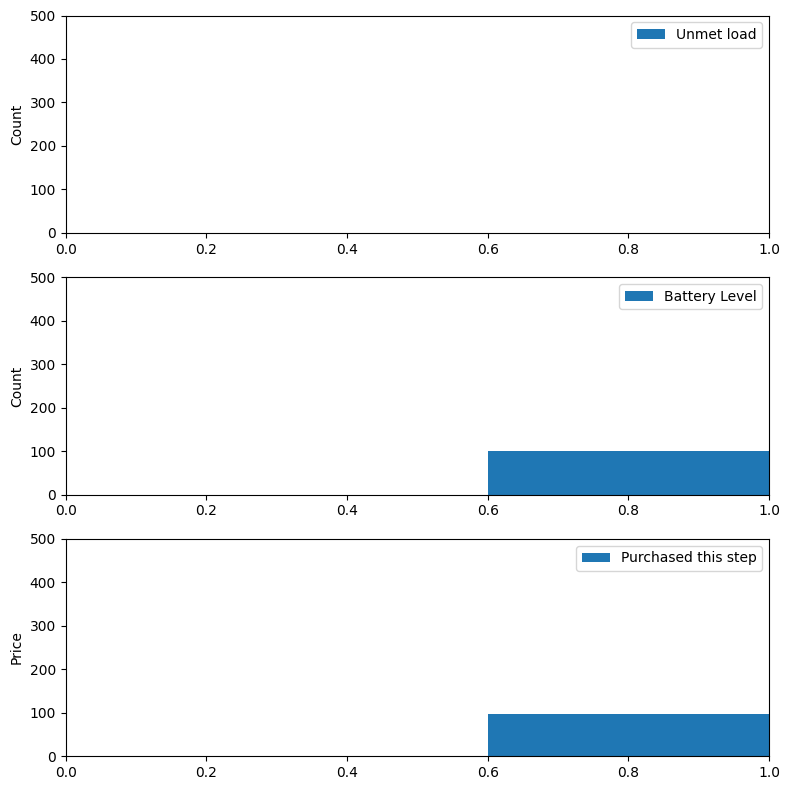

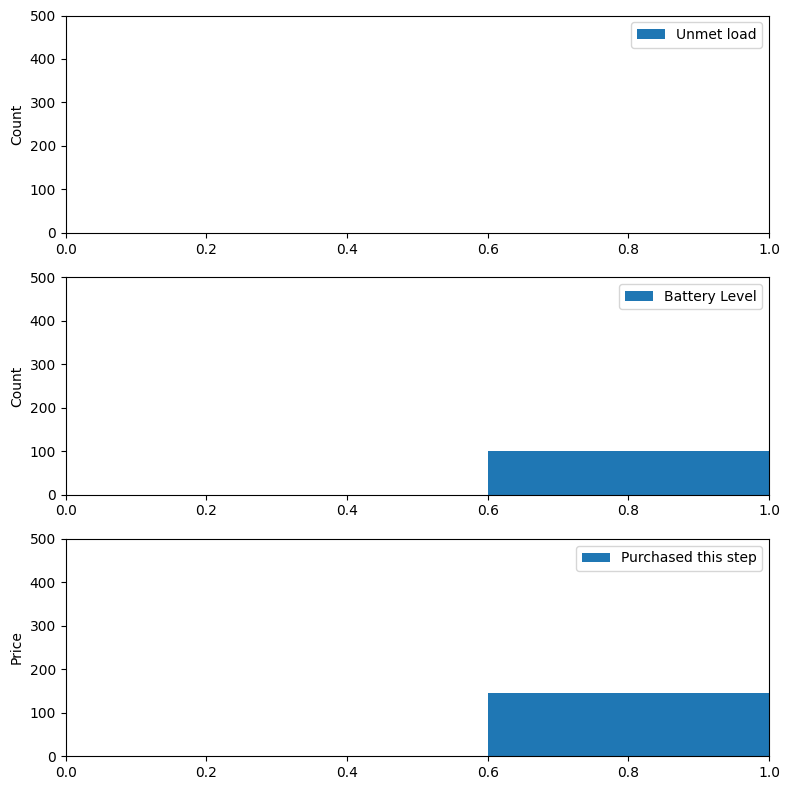

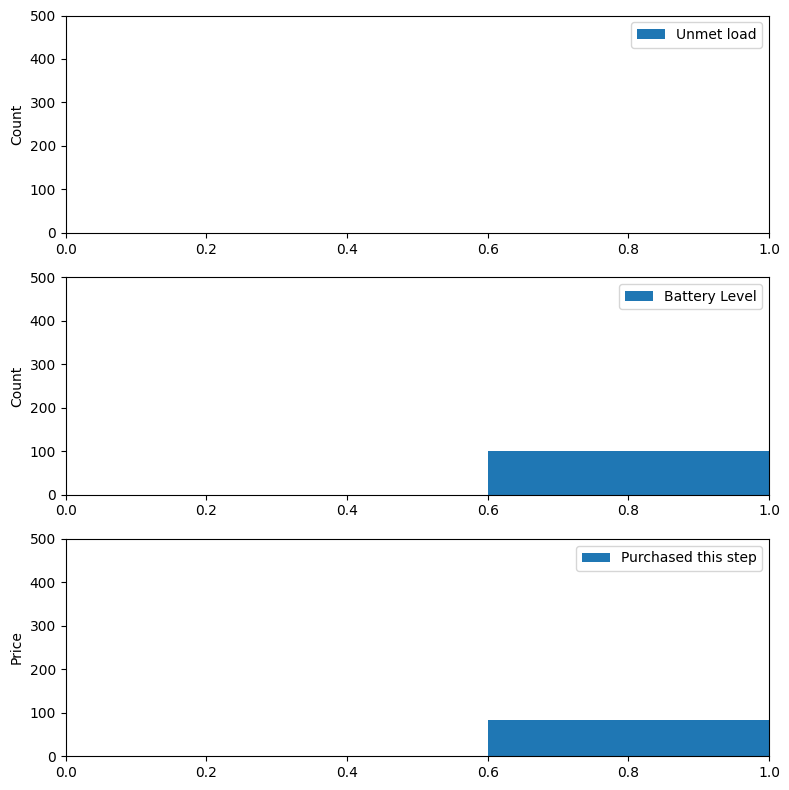

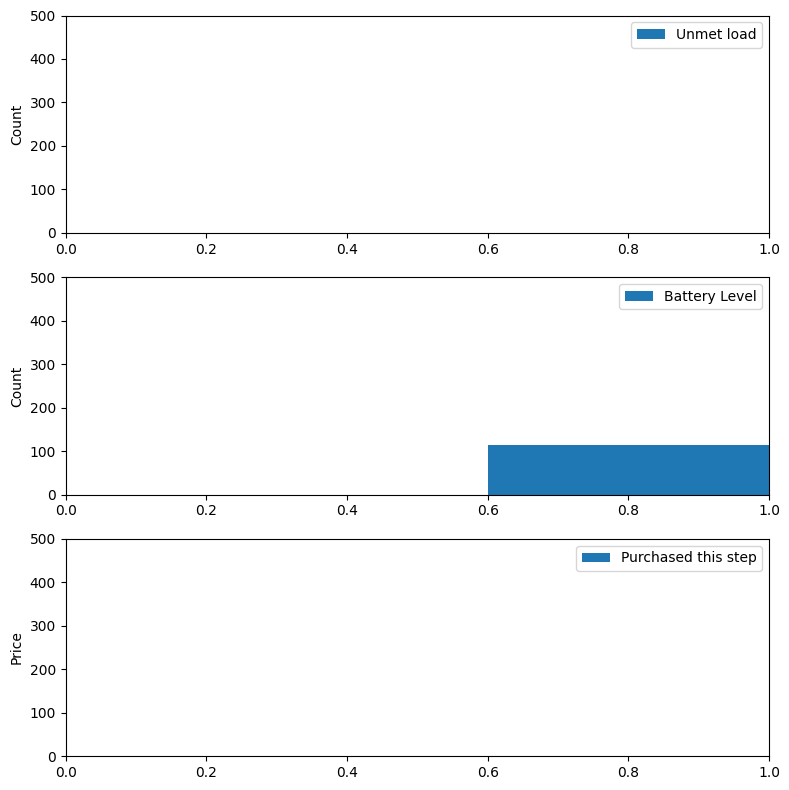

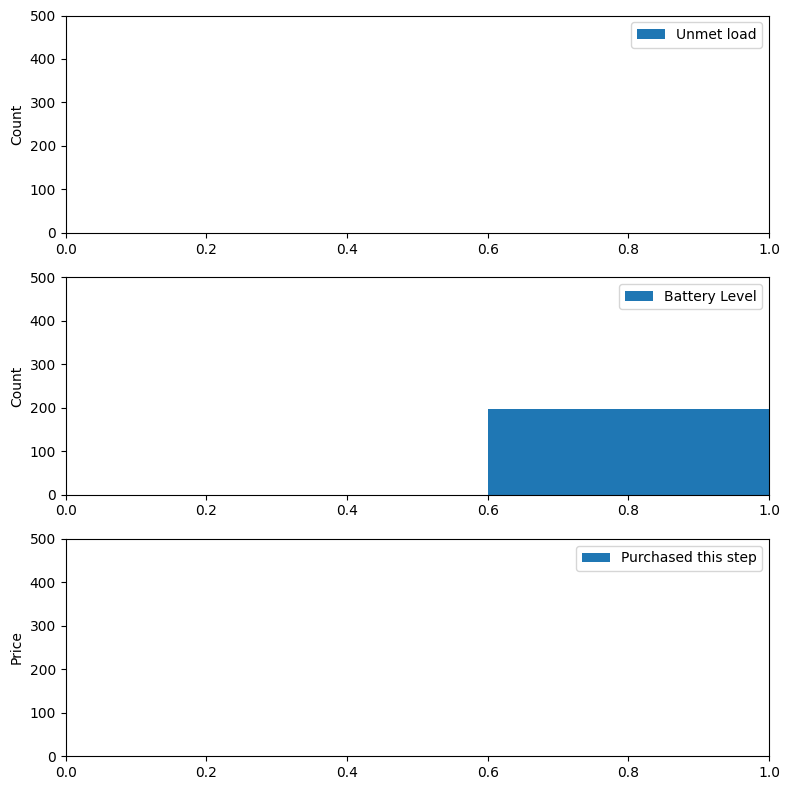

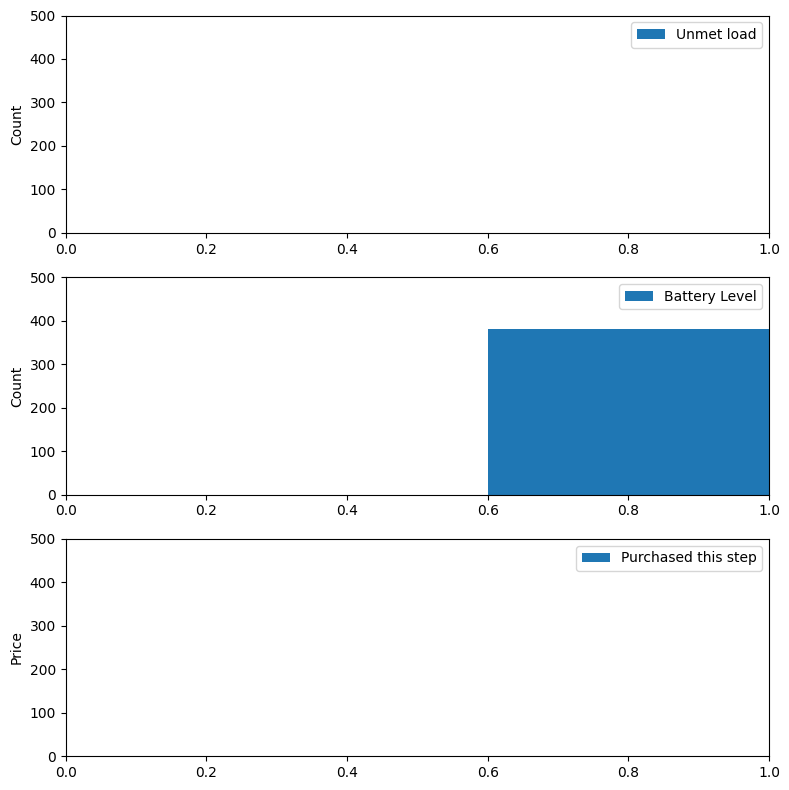

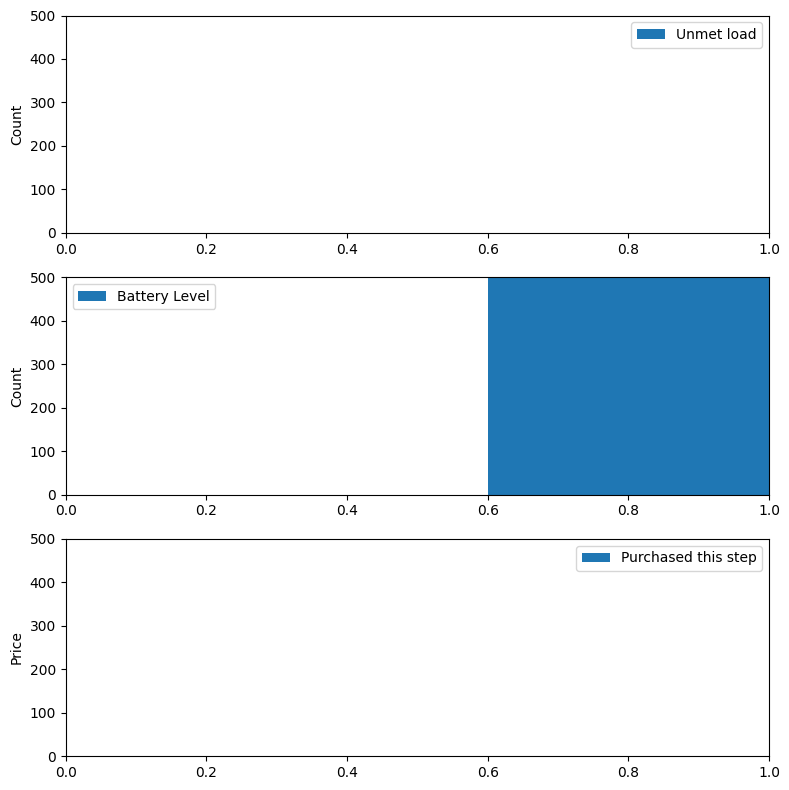

KeyboardInterrupt: ignored

In [82]:
#need to import data from Github
path_data = "/content/EEE4022S_BNKJUL001_Thesis/PythonWorkspace/dataClean.csv"
data = pd.read_csv(path_data)

path_gen = "/content/EEE4022S_BNKJUL001_Thesis/Generation/BNKJUL001_Thesis_solarGen500kWHomer.csv"
data_gen = pd.read_csv(path_gen)

#Not actually using this rn but will be soon :)
path_shedding = "/content/EEE4022S_BNKJUL001_Thesis/MatlabWorkSpace/loadShedding2022.csv"
data_shedding = pd.read_csv(path_shedding)
load_shedding = data_shedding['LoadShedding'].values.astype(np.float32)

actual_gen = data_gen['PV_Out'].values.astype(np.float32)
actual_load = data['AC'].values.astype(np.float32)
purchase_price = data['tou_id'].values.astype(np.float32)


#define the base environment
base_env = EMS(episode_len = 6000, actual_load = actual_load, actual_gen = actual_gen, bat_threshold = 100, bat_cap = 500, purchase_price = purchase_price,num_preds = 3)
#going to print out a bunch of things to test the different spaces.
obs,_    = base_env.reset()
print(f"The reset observation space looks like: {obs}")
action_standby = 0
obs,reward,terminated,truncated,info = base_env.step(action_standby)
print(f"After action {action_standby} the observation space looks like {obs}")
print(f"The reward we recieved was {reward}")

#Evaluate the base model (no EMS, just using standby mode)
#A loop to get an average reward for the base model only perfoming the standby option
#reset the environment and save the obs
#going to run it 100 times to get a benchmark
#reset score
score = 0

obs,_    = base_env.reset()
#ensure that the exit condition is reset
truncated = False
#define the action to take
action_standby = 0

while not truncated:
    obs,reward,terminated,truncated,info = base_env.step(action_standby)
    score += reward

print(f"Done iteration! Total reward accumulated is: {score}")

**LOAD OR MAKE MODEL HERE!**

In [ ]:
config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": 1500000,
}

run = wandb.init(
    project="4022_intelligent_ems",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

train_args = {
                "episode_len"   :6000,
                "actual_load"   :actual_load,
                "actual_gen"    :actual_gen,
                "bat_threshold" :100,
                "bat_cap"       :500,
                "purchase_price":purchase_price,
                "num_preds"     :3,
                "load_shedding" :load_shedding
                }

eval_args = {
                "episode_len"   :2760,
                "actual_load"   :actual_load[6001:],
                "actual_gen"    :actual_gen[6001:],
                "bat_threshold" :100,
                "bat_cap"       :500,
                "purchase_price":purchase_price[6001:],
                "num_preds"     :3,
                "load_shedding" :load_shedding[6001:]
}

#define 5 environments   for training and eval
n_envs = 10
n_eval_episodes =1
train_env = make_vec_env(EMS, n_envs = n_envs,env_kwargs = train_args )

eval_env = make_vec_env(EMS, n_envs = n_envs,env_kwargs = eval_args )


wand_eval = f"{version}_{model_type}_eval"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
wand_train = f"{version}_{model_type}_train"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

wandb_callback = WandbCallback(
                gradient_save_freq=100,
                model_save_path=f"models/{run.id}",
                model_save_freq= 30000,
                verbose=2,
                log = "all",
               )
eval_callback = EvalCallback(eval_env,
                             best_model_save_path = f"{model_dir}{version}_{model_type}"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                             log_path = wand_eval,
                             eval_freq=300,
                             n_eval_episodes = n_eval_episodes,
                             deterministic = True,
                             render = False,
                             callback_after_eval = wandb_callback)


model = DQN("MultiInputPolicy",train_env, verbose = 1, tensorboard_log = f"runs/{run.id}") #log_dir

model.learn(total_timesteps= config["total_timesteps"],
            tb_log_name = wand_train,
            reset_num_timesteps=False,
            callback = wandb_callback
            )
model.save(f"{model_dir}{version}_{model_type}"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


**Define a new test environment and load up the best performing model to test it.**

In [ ]:
eval_env.render(save_path=f"{model_dir}/animation")

In [58]:


#Load model, fetch the latest (or whichever one you want from the model_dir)
#Best A2C model:/content/drive/MyDrive/Colab Notebooks/EMSv0_3/models/PPO/EMSv0_3_PPO20231005-102532.zip
#best_PPO_model = "EMSv0_3_PPO20231006-204045.zip"

#model_load = f"{model_dir}/{best_PPO_model}"
#model  = PPO.load(model_load, env = eval_env)

#first run it with only standby (default)
obs   = eval_env.reset()
#ensure that the exit condition is reset
done = [False]*n_envs
#define the action to take
action_standby = [0]*n_envs
#reset score
standby_score = [0]*n_envs
standby_score = np.array(standby_score).astype(np.float32)
while not all(done):
    #step the model with the action
    obs,reward,done,info = eval_env.step(action_standby)
    #accumulate the score
    standby_score += reward

avg_standby_score = standby_score.mean()

EMS_reward,EMS_std_reward = evaluate_policy(model,eval_env,n_eval_episodes = 20,deterministic=True)# callback = wandb_callback

run.finish()
print(f"Note: The term does not refer to the cost in rands but rather to the reward as defined by the reward function!")
print(f"Done the Standby Test! Total cost accumulated is: {avg_standby_score}")
print(f"Done applying the trained model! Total cost accumulated is: {EMS_reward} +- {EMS_std_reward}")

savings = EMS_reward - avg_standby_score
print(f"The amount that was saved by applying the EMS agent: {savings}")
print(f"This was saved over a period of {2760/24} days")
print(f"The savings represents {(savings/(-avg_standby_score))*100} % of the cost if no EMS is installed")
print(f"And it represents {(savings/(-EMS_reward))*100} % of the cost if the EMS is installed")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,▁▂▄▄▅▅▅▆▆▆▇▇▇████████████
rollout/exploration_rate,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▃▁▃▄▆▇▇▆▆▆▆▇▇▇▇▇▇████████
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▃▁▂▂▄▃▄▄▅▄▆▅▇▅▆█▇▇▇▆▇▆▇▅█
global_step,1498750
rollout/ep_len_mean,5995.0
rollout/ep_rew_mean,-893647.0625
rollout/exploration_rate,0.05


Note: The term does not refer to the cost in rands but rather to the reward as defined by the reward function!
Done the Standby Test! Total cost accumulated is: -440125.59375
Done applying the trained model! Total cost accumulated is: -495958.1832960001 +- 1.1641532182693481e-10
The amount that was saved by applying the EMS agent: -55832.58954600012
This was saved over a period of 115.0 days
The savings represents -12.68560391371244 % of the cost if no EMS is installed
And it represents -11.257519570491258 % of the cost if the EMS is installed
